# DS 677 Research Project -- Predicting the Past

This is a research project in Prof. Koutis' DS 677 Deep Learning course at NJIT.  The group working on this project consists of Kevin Kaplan, Travis Virgil, and Christopher Guarino.  

## Intro

The main research interest in this project is to examine the flow of time in time series models, and determine if we can gain any insights into model performance based on predictions of the past data.  

From the document provided in class: 

"This is a project on time series and it will involve some experimentation with recurrent layers and transformers. 
Suppose (X, Y ) is training set, where each training datum Xi is a sequence of vectors:

Xi = {Xi,1, . . . , Xi,t}

and Yi is a label that can be derived as a function of Xi and Xi,t+1, and it can be categorical or numerical.
In concrete terms, you can think of the dataset as weather data. Each vector Xi,j is a set of measurements
from a weather station, and the ‘datum’ Xi is a sequence of measurements over time. Yi in this case 
may be a vector of measurements at t + 1, or even a general categorization of the weather for time t + 1.

The labels Yi can be either numerical (regression), or categorical (classification), e.g. reflecting a price prediction 
vs a direction prediction etc. As an example, we can think of Yi, being derived from Xi,t+1.
There are a lot of efforts on creating models that do some type of forward prediction, e.g. predict Yi = Xi,t+1,
as this is the most practically relevant question. But what if we change/augment our target?

• Experiment-1: Create a dataset where the sequence is reversed: {Xi,t, . . . , Xi,1}, and the label is derived
from Xi,0 (e.g. Yi = Xi,0), which amounts to ‘predicting the past’. What is the performance of such a
model? Does the model have a better performance? Is convergence faster? In some sense, that is a
philosophically fundamental question: is there an arrow of time?

• Experiment-2: Given a time sequence {Xi,1, . . . , Xi,t}, we can also try to predict both Xi,1 and Xi,t given
the rest of the sequence. If that is the case, then we can model the total loss L as a sum of two losses
L1 and L2. Another way of looking at the time arrow question is to see the behavior of L. Does L1 get
reduced faster than L2, or at the same rate?

• Experiment-3: How predicting the past may also be relevant in practice: Another question related to
experiment-2 is this. Suppose we have trained a model to minimize L, i.e. predict both the past and the
future. During the test/evaluation phase, is there a correlation between the accuracy of the backward
and forward prediction? Notice that if there is such a correlation, that would be a very interesting
information to have when the model is deployed. During deployment, we will always be able to check
the accuracy of the past prediction (because we know the past!), and using the correlation we may be
able to have a degree of certainty for the future prediction. (On the other hand, if the past prediction is
not accurate that may indicate market volatility etc)."

## Imports

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import pandas as pd


In [2]:
from utils import *

In [3]:
from model_utils import *

In [4]:
# sets random seed for everything
set_seed(13)

In [5]:
from e2u import *

## Data

The data used for the following experiments is time series data.  First, simple sin wave data is used to look into the questions, and then stock market data is used after that.  The data for each experiment is put into pytorch datasets and then into pytorch dataloaders for use with training and testing.  For each experiment, the specific data and preparations for that experiment will be discussed in the experiment data sections.

## Experiment 1

### Experiment 1 Intro

From class: 

"Experiment-1: Create a dataset where the sequence is reversed: {Xi,t, . . . , Xi,1}, and the label is derived
from Xi,0 (e.g. Yi = Xi,0), which amounts to ‘predicting the past’. What is the performance of such a
model? Does the model have a better performance? Is convergence faster? In some sense, that is a
philosophically fundamental question: is there an arrow of time?"

Here we will test this by creating one model architecture, a simple LSTM, and testing both the forward and reverse data using the same model architecture and parameters. We will use simple sine wave data to test it, and compare the results for each.

### Data

The data is generated from a sine wave with the function get_sin_data() from the utils folder.  A small amount of noise is added to the data as well. It takes the data, and creates sequences with the desired time window size, and creates the label as the next time step.  So, we will be predicting a single value-- the next time step in a sequence. The function can generate both forward and reverse data, as well as optionally provide a graph.  Here the forward and backward data are generated and the graphs are shown.  After the data is generated, it is loaded into torch datasets for use in dataloaders.

In [241]:
T = 10000 # number of data points
tau = 50 # sequence window size

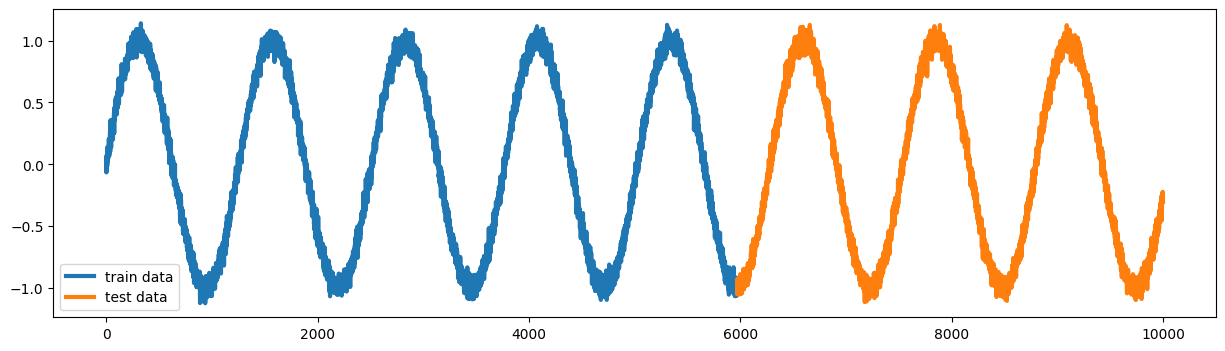

In [242]:
# Generate forward data
X_train_fwd, y_train_fwd, X_val_fwd, y_val_fwd, X_test_fwd, y_test_fwd = gen_sin_data(T, tau)

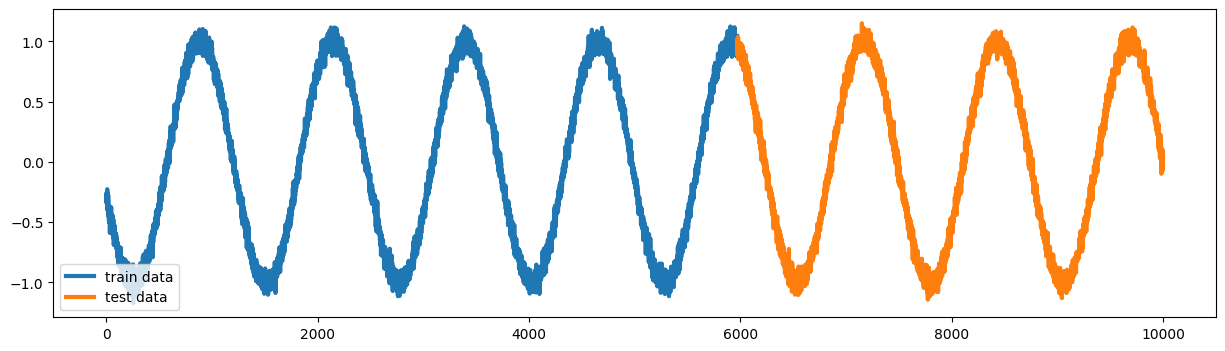

In [243]:
# Generate reverse data
X_train_rev, y_train_rev, X_val_rev, y_val_rev, X_test_rev, y_test_rev = gen_sin_data(T, tau, rev=True)

In [244]:
batch_size = 32

In [245]:
# Create datasets and dataloaders
# fwd datasets
train_data_fwd = TensorDataset(X_train_fwd, y_train_fwd)
val_data_fwd = TensorDataset(X_val_fwd, y_val_fwd)
test_data_fwd = TensorDataset(X_test_fwd, y_test_fwd)

# rev datasets
train_data_rev = TensorDataset(X_train_rev, y_train_rev)
val_data_rev = TensorDataset(X_val_rev, y_val_rev)
test_data_rev = TensorDataset(X_test_rev, y_test_rev)

# fwd loaders
train_loader_fwd = DataLoader(dataset=train_data_fwd, batch_size=batch_size, shuffle=True)
val_loader_fwd = DataLoader(dataset=val_data_fwd, batch_size=batch_size, shuffle=True)
test_loader_fwd = DataLoader(dataset=test_data_fwd, batch_size=batch_size, shuffle=False)

# rev loaders
train_loader_rev = DataLoader(dataset=train_data_rev, batch_size=batch_size, shuffle=True)
val_loader_rev = DataLoader(dataset=val_data_rev, batch_size=batch_size, shuffle=True)
test_loader_rev = DataLoader(dataset=test_data_rev, batch_size=batch_size, shuffle=False)

### Model

The aim is to keep the model as simple as possible.  Here is the code for the LSTM model used in this experiment.  It simply has one lstm layer and a single linear output layer.

In [6]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTMModel, self).__init__()

        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)  

        return out

### Example Training and Testing

#### Training

To show how the models are trained and evaluated in this experiment, here is an example training, testing, and analyzing the results of a forward and reverse model.  Again, everything is kept as simple as possible, the focus here is on the results, not the model itself.  A hidden size of 4, learning rate of .001, Adam optimizer, and Mean Squared Error Loss Function are used for the models in this experiment.

In [12]:
input_size = 1
hidden_size = 4
lr = .001

In [13]:
model_fwd = LSTMModel(input_size, hidden_size)
model_rev = LSTMModel(input_size, hidden_size)

In [14]:
loss_fn = nn.MSELoss()
opt_fwd = optim.Adam(model_fwd.parameters(), lr=lr)
opt_rev = optim.Adam(model_rev.parameters(), lr=lr)

/Users/kevinkaplan/tensorflow-test/env/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [15]:
losses_train_fwd = []
losses_val_fwd = []

losses_train_rev = []
losses_val_rev = []

In [16]:
n_epochs = 200

In [17]:
# forward training loop
for epoch in range(n_epochs):
    tot_train = 0.0
    tot_val = 0.0
    
    # Training 
    model_fwd.train()  
    for inputs, labels in train_loader_fwd:
        outputs = model_fwd(inputs)
        loss = loss_fn(outputs, labels)
        
        opt_fwd.zero_grad()
        loss.backward()
        opt_fwd.step()
        
        tot_train += loss.item()
    
    losses_train_fwd.append(tot_train / len(train_loader_fwd.sampler))
    
    # Validation 
    model_fwd.eval()  
    with torch.no_grad():
        for inputs_val, labels_val in val_loader_fwd:
            outputs_val = model_fwd(inputs_val)
            val_loss = loss_fn(outputs_val, labels_val)
            tot_val += val_loss.item()
    
    losses_val_fwd.append(tot_val / len(val_loader_fwd.sampler))

In [18]:
# reverse model
for epoch in range(n_epochs):
    tot_train = 0.0
    tot_val = 0.0
    
    # Training 
    model_rev.train()  
    for inputs, labels in train_loader_rev:
        outputs = model_rev(inputs)
        loss = loss_fn(outputs, labels)
        
        opt_rev.zero_grad()
        loss.backward()
        opt_rev.step()
        
        tot_train += loss.item()

    losses_train_rev.append(tot_train / len(train_loader_rev.sampler))
    
    # Validation 
    model_rev.eval()  
    with torch.no_grad():
        for inputs_val, labels_val in val_loader_rev:
            outputs_val = model_rev(inputs_val)
            val_loss = loss_fn(outputs_val, labels_val)
            tot_val += val_loss.item()
    
    losses_val_rev.append(tot_val / len(val_loader_rev.sampler))

#### Loss Curves

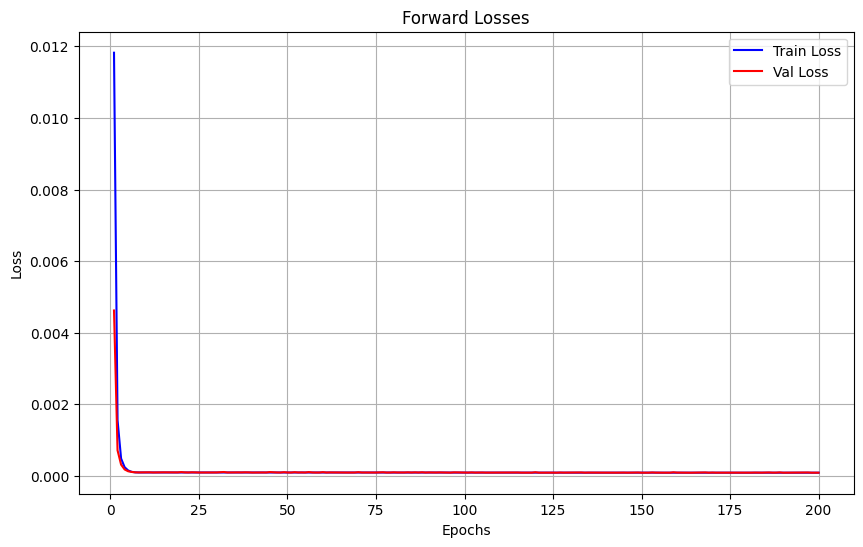

In [19]:
# forward losses
epochs = range(1, len(losses_train_fwd) + 1)

plt.figure(figsize=(10, 6))

plt.plot(epochs, losses_train_fwd, label='Train Loss', color='blue')
plt.plot(epochs, losses_val_fwd, label='Val Loss', color='red')

plt.title('Forward Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# plt.xlim(0, 50)
plt.legend()
plt.grid(True)
plt.show()

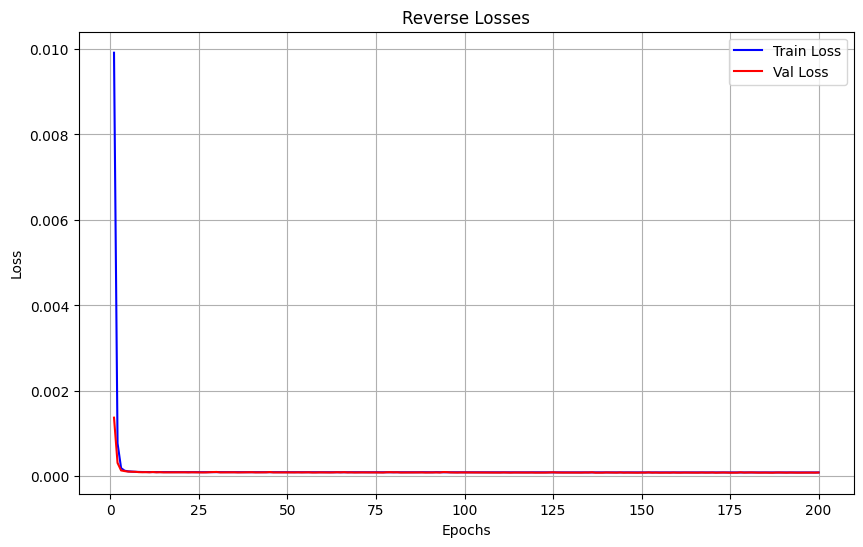

In [20]:
# reverse losses
epochs = range(1, len(losses_train_rev) + 1)

plt.figure(figsize=(10, 6))

plt.plot(epochs, losses_train_rev, label='Train Loss', color='blue')
plt.plot(epochs, losses_val_rev, label='Val Loss', color='red')

plt.title('Reverse Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# plt.xlim(0, 50)

plt.legend()
plt.grid(True)
plt.show()

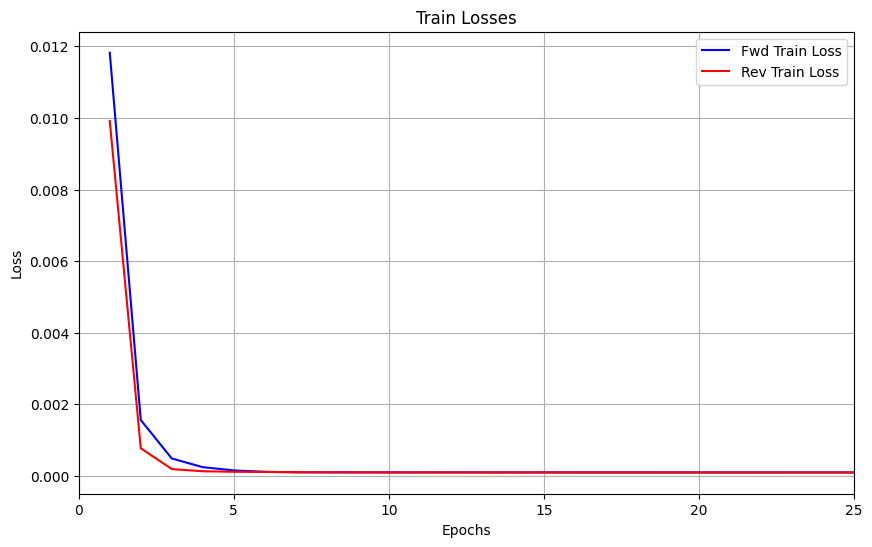

In [21]:
# forward vs reverse losses-- train
epochs = range(1, len(losses_train_rev) + 1)

plt.figure(figsize=(10, 6))

plt.plot(epochs, losses_train_fwd, label='Fwd Train Loss', color='blue')
plt.plot(epochs, losses_train_rev, label='Rev Train Loss', color='red')

plt.title('Train Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xlim(0, 25)

plt.legend()
plt.grid(True)
plt.show()

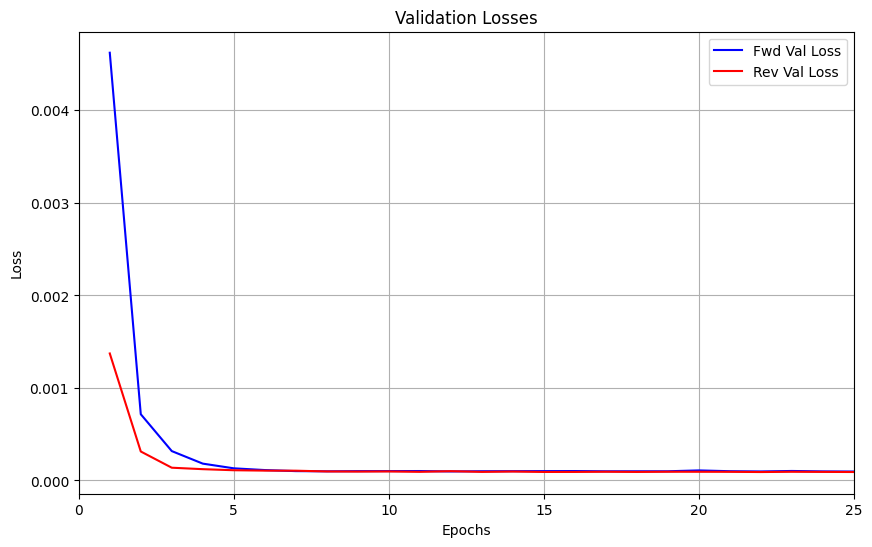

In [22]:
# forward vs reverse losses-- val
epochs = range(1, len(losses_val_rev) + 1)

plt.figure(figsize=(10, 6))

plt.plot(epochs, losses_val_fwd, label='Fwd Val Loss', color='blue')
plt.plot(epochs, losses_val_rev, label='Rev Val Loss', color='red')

plt.title('Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xlim(0, 25)

plt.legend()
plt.grid(True)
plt.show()

#### Testing

In [23]:
preds_fwd = []
true_fwd = []

# Set the model to evaluation mode
model_fwd.eval()


# Make predictions
with torch.no_grad():
     for inputs, labels in test_loader_fwd:

        out = model_fwd(inputs)
        preds_fwd.append(out.cpu().numpy())
        true_fwd.append(labels.cpu().numpy())

       
preds_fwd = np.concatenate(preds_fwd).flatten()
true_fwd = np.concatenate(true_fwd).flatten()

In [24]:
preds_rev = []
true_rev = []

# Set the model to evaluation mode
model_rev.eval()


# Make predictions
with torch.no_grad():
     for inputs, labels in test_loader_rev:
        out = model_rev(inputs)

        preds_rev.append(out.cpu().numpy())
        true_rev.append(labels.cpu().numpy())

       
preds_rev = np.concatenate(preds_rev).flatten()
true_rev = np.concatenate(true_rev).flatten()

In [25]:
# mean abs error
mae = mean_absolute_error(true_fwd, preds_fwd)

# mean squared error
mse = mean_squared_error(true_fwd, preds_fwd)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)

Mean Absolute Error: 0.04290759
Mean Squared Error: 0.002878842


In [26]:
# mean abs error
mae = mean_absolute_error(true_rev, preds_rev)

# mean squared error
mse = mean_squared_error(true_rev, preds_rev)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)

Mean Absolute Error: 0.044032026
Mean Squared Error: 0.0030904033


In [27]:
time = torch.arange(.8*T, T, dtype=torch.float32)
sin = torch.sin(0.005 * time)

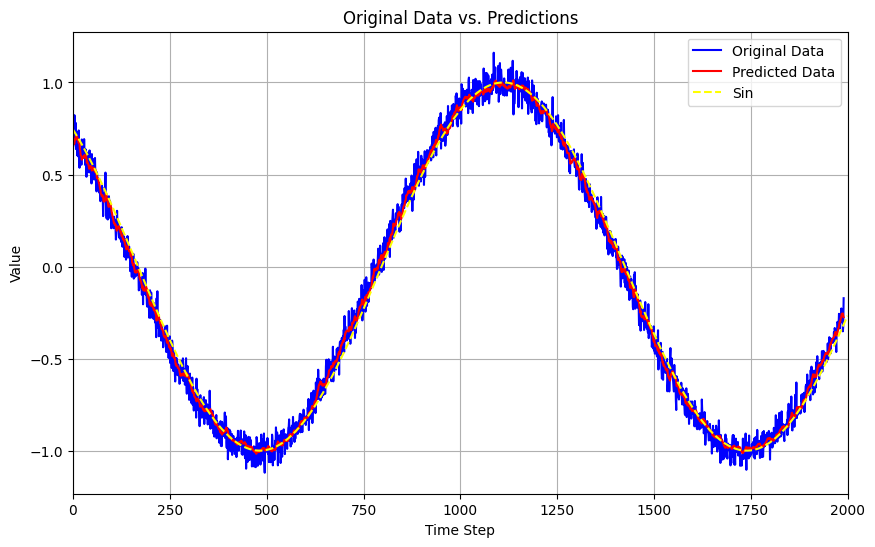

In [28]:
plt.figure(figsize=(10, 6))
plt.plot(true_fwd, label='Original Data', color='blue')
plt.plot(preds_fwd, label='Predicted Data', color='red')
plt.plot(sin, label='Sin', linestyle='--', color='yellow')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Original Data vs. Predictions')
plt.legend()
plt.grid(True)
start_time_step = 0  # Start time step
end_time_step = 2000  # End time step (adjust as needed)
plt.xlim(start_time_step, end_time_step)
plt.show()

In [29]:
time = torch.arange(0, T, dtype=torch.float32)
sin = torch.sin(0.005 * time)
sin = reversed(sin)

sin = sin[8000 : T]

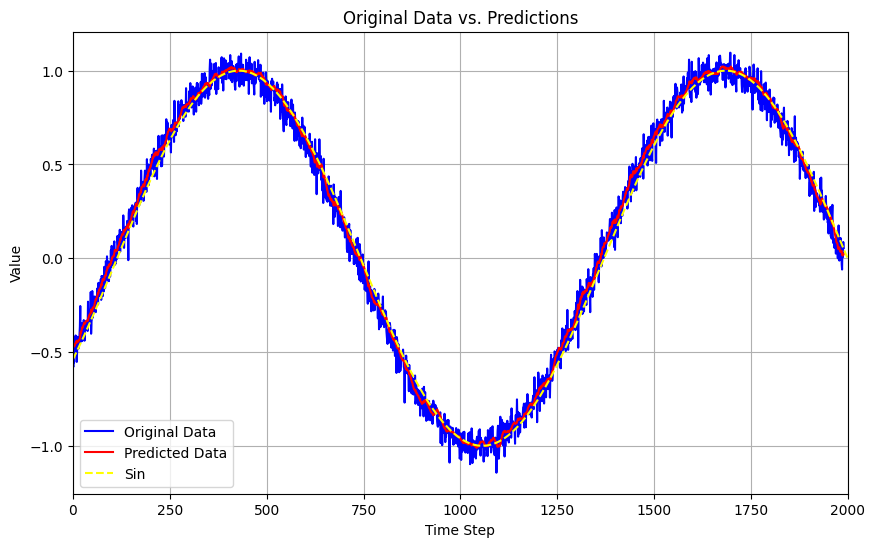

In [30]:
plt.figure(figsize=(10, 6))
plt.plot(true_rev, label='Original Data', color='blue')
plt.plot(preds_rev, label='Predicted Data', color='red')
plt.plot(sin, label='Sin', linestyle='--', color='yellow')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Original Data vs. Predictions')
plt.legend()
plt.grid(True)
start_time_step = 0  # Start time step
end_time_step = 2000  # End time step (adjust as needed)
plt.xlim(start_time_step, end_time_step)
plt.show()

### Running the Experiment

In [31]:
# fwd_result, rev_result = exp_1_pipeline(3)

In [247]:
from model_utils import *

In [248]:
lrs = [.1, .01, .005, .001, .0005]
hiddens = [4, 8, 16]
num_runs = 5

In [249]:
fwd_results = []
rev_results = []

In [ ]:
for lr in lrs:
    for hidden_size in hiddens:
        mae_fwd_tot = 0
        mse_fwd_tot = 0
        mae_rev_tot = 0
        mse_rev_tot = 0

        for i in range(num_runs):

            model_fwd = LSTMModel(input_size, hidden_size)
            model_rev = LSTMModel(input_size, hidden_size)

            loss_fn = nn.MSELoss()

            opt_fwd = optim.Adam(model_fwd.parameters(), lr=lr)
            opt_rev = optim.Adam(model_rev.parameters(), lr=lr)

            fwd_result = train_e1_model(model_fwd, train_loader_fwd, val_loader_fwd, loss_fn, opt_fwd)
            rev_result = train_e1_model(model_rev, train_loader_rev, val_loader_rev, loss_fn, opt_rev)

            fwd_results.append((fwd_result, lr, hidden_size, i))
            rev_results.append((rev_result, lr, hidden_size, i))

            best_model_state_dict_fwd, best_epoch_fwd, losses_train_fwd, losses_val_fwd = fwd_result
            best_model_state_dict_rev, best_epoch_rev, losses_train_rev, losses_val_rev = rev_result

            model_fwd.load_state_dict(best_model_state_dict_fwd)
            model_rev.load_state_dict(best_model_state_dict_rev)

            print(f'LR: {lr}, Hidden Size: {hidden_size}, Iteration: {i + 1}')
            preds_fwd, true_fwd = make_preds(model_fwd, test_loader_fwd)
            preds_rev, true_rev = make_preds(model_rev, test_loader_rev)

            mae_fwd, mse_fwd = get_metrics(preds_fwd, true_fwd)
            mae_rev, mse_rev = get_metrics(preds_rev, true_rev)

            mae_fwd_tot += mae_fwd
            mse_fwd_tot += mse_fwd
            mae_rev_tot += mae_rev
            mse_rev_tot += mse_rev

            

### Results

#### Code

In [297]:
data = {
    # 'idx': [],
    'lr': [],
    'hidden_size': [],
    'i': [],
    'best_epoch_fwd': [],
    'best_epoch_rev': [],
    'mae_fwd': [],
    'mae_rev': [],
    'mse_fwd': [],
    'mse_rev': []
}





In [298]:
idx = 0
for k in range(len(fwd_results)):
    fwd_result, lr, hidden_size, i = fwd_results[k]
    rev_result, lr, hidden_size, i = rev_results[k]
    
    best_model_state_dict_fwd, best_epoch_fwd, losses_train_fwd, losses_val_fwd = fwd_result
    best_model_state_dict_rev, best_epoch_rev, losses_train_rev, losses_val_rev = rev_result

    model_fwd = LSTMModel(input_size, hidden_size)
    model_rev = LSTMModel(input_size, hidden_size)

    model_fwd.load_state_dict(best_model_state_dict_fwd)
    model_rev.load_state_dict(best_model_state_dict_fwd)

    preds_fwd, true_fwd = make_preds(model_fwd, test_loader_fwd)
    preds_rev, true_rev = make_preds(model_rev, test_loader_rev)

    mae_fwd, mse_fwd = get_metrics(preds_fwd, true_fwd)
    mae_rev, mse_rev = get_metrics(preds_rev, true_rev)
    
    # data['idx'].append(k)
    data['lr'].append(lr)
    data['hidden_size'].append(hidden_size)
    data['i'].append(i)
    data['best_epoch_fwd'].append(best_epoch_fwd)
    data['mae_fwd'].append(mae_fwd)
    data['mse_fwd'].append(mse_fwd)
    data['best_epoch_rev'].append(best_epoch_rev)
    data['mae_rev'].append(mae_rev)
    data['mse_rev'].append(mse_rev)
    

In [299]:
import pandas as pd

df = pd.DataFrame(data)

In [445]:
df

lr  hidden_size  i  best_epoch_fwd  best_epoch_rev   mae_fwd  \
0   0.1000            4  0              37              37  0.042058   
1   0.1000            4  0              31              31  0.043858   
2   0.1000            4  0              89              56  0.042753   
3   0.1000            4  1              46              41  0.042817   
4   0.1000            4  2              29              85  0.043514   
..     ...          ... ..             ...             ...       ...   
72  0.0005           16  0              90              78  0.041719   
73  0.0005           16  1              92              99  0.041953   
74  0.0005           16  2              97              98  0.042819   
75  0.0005           16  3              65              92  0.041923   
76  0.0005           16  4              93              95  0.041863   

     mae_rev   mse_fwd   mse_rev  epoch_diff  pct_diff_mae  pct_diff_mse  
0   0.042112  0.002790  0.002835           0      0.129064      1.616232  
1   0.043806  0.003039  0.003031           0     -0.118117     -0.289184  
2   0.042410  0.002870  0.002848         -33     -0.802335     -0.765566  
3   0.042150  0.002856  0.002801          -5     -1.557480     -1.923446  
4   0.043147  0.002987  0.002967          56     -0.842686     -0.686878  
..       ...       ...       ...         ...           ...           ...  
72  0.041674  0.002728  0.002754         -12     -0.108135      0.959063  
73  0.041809  0.002754  0.002761           7     -0.342470      0.235844  
74  0.042486  0.002882  0.002877           1     -0.779176     -0.166596  
75  0.041719  0.002746  0.002756          27     -0.486530      0.370989  
76  0.041638  0.002742  0.002764           2     -0.536344      0.797961  

[77 rows x 12 columns]

In [301]:
df['epoch_diff'] = df['best_epoch_rev'] - df['best_epoch_fwd']

In [303]:
df['pct_diff_mae'] = ((df['mae_rev'] - df['mae_fwd']) / df['mae_fwd']) * 100
df['pct_diff_mse'] = ((df['mse_rev'] - df['mse_fwd']) / df['mse_fwd']) * 100

In [304]:
df

lr  hidden_size  i  best_epoch_fwd  best_epoch_rev   mae_fwd  \
0   0.1000            4  0              37              37  0.042058   
1   0.1000            4  0              31              31  0.043858   
2   0.1000            4  0              89              56  0.042753   
3   0.1000            4  1              46              41  0.042817   
4   0.1000            4  2              29              85  0.043514   
..     ...          ... ..             ...             ...       ...   
72  0.0005           16  0              90              78  0.041719   
73  0.0005           16  1              92              99  0.041953   
74  0.0005           16  2              97              98  0.042819   
75  0.0005           16  3              65              92  0.041923   
76  0.0005           16  4              93              95  0.041863   

     mae_rev   mse_fwd   mse_rev  epoch_diff  pct_diff_mae  pct_diff_mse  
0   0.042112  0.002790  0.002835           0      0.129064      1.616232  
1   0.043806  0.003039  0.003031           0     -0.118117     -0.289184  
2   0.042410  0.002870  0.002848         -33     -0.802335     -0.765566  
3   0.042150  0.002856  0.002801          -5     -1.557480     -1.923446  
4   0.043147  0.002987  0.002967          56     -0.842686     -0.686878  
..       ...       ...       ...         ...           ...           ...  
72  0.041674  0.002728  0.002754         -12     -0.108135      0.959063  
73  0.041809  0.002754  0.002761           7     -0.342470      0.235844  
74  0.042486  0.002882  0.002877           1     -0.779176     -0.166596  
75  0.041719  0.002746  0.002756          27     -0.486530      0.370989  
76  0.041638  0.002742  0.002764           2     -0.536344      0.797961  

[77 rows x 12 columns]

In [305]:
results = df[['epoch_diff', 'pct_diff_mae', 'pct_diff_mse']]

#### Output

The results do not indicate that there is one model significantly outperforming another. We see the greatest difference in accuracies being roughly 2.5%, but a fairly even spread between the trials in both metrics.  There is some slight evidence that the reverse data model trains better, with a faster convergence.  We can see this in the loss curve from the example, as well as seeing more frequent and greater values in the 'epoch_diff' column.  This is simply the difference between the epoch of convergence for the forward and reverse models.  A negative value indicates the forward had a faster convergence, and a positive value indicates the reverse did.

In [306]:
results

epoch_diff  pct_diff_mae  pct_diff_mse
0            0      0.129064      1.616232
1            0     -0.118117     -0.289184
2          -33     -0.802335     -0.765566
3           -5     -1.557480     -1.923446
4           56     -0.842686     -0.686878
..         ...           ...           ...
72         -12     -0.108135      0.959063
73           7     -0.342470      0.235844
74           1     -0.779176     -0.166596
75          27     -0.486530      0.370989
76           2     -0.536344      0.797961

[77 rows x 3 columns]

In [307]:
max_pct_diff_mae = df['pct_diff_mae'].max()
min_pct_diff_mae = df['pct_diff_mae'].min()

max_pct_diff_mse = df['pct_diff_mse'].max()
min_pct_diff_mse = df['pct_diff_mse'].min()

In [308]:
print("Maximum pct_diff_mae:", max_pct_diff_mae)
print("Minimum pct_diff_mae:", min_pct_diff_mae)

print("Maximum pct_diff_mse:", max_pct_diff_mse)
print("Minimum pct_diff_mse:", min_pct_diff_mse)

Maximum pct_diff_mae: 0.7080679
Minimum pct_diff_mae: -1.5574802
Maximum pct_diff_mse: 2.4374313
Minimum pct_diff_mse: -1.9234456


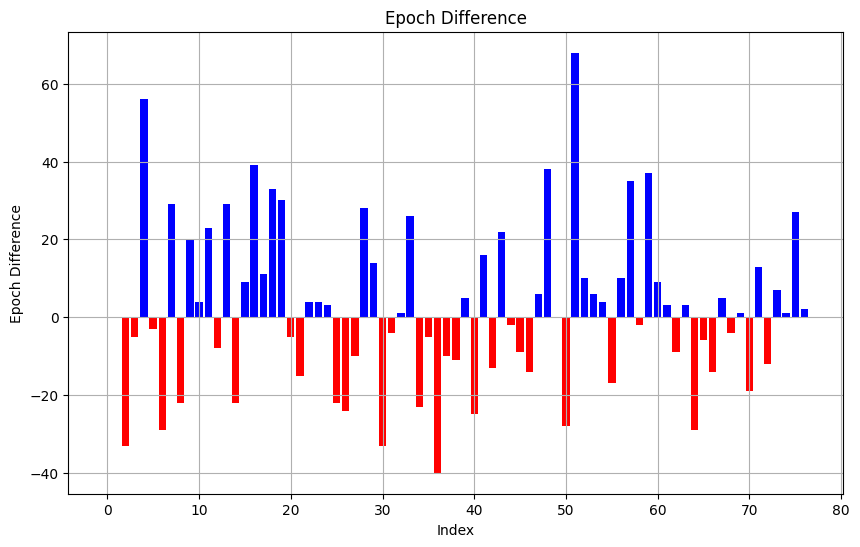

In [311]:
colors = ['red' if x < 0 else 'blue' for x in df['epoch_diff']]
plt.figure(figsize=(10, 6))
plt.bar(df.index, df['epoch_diff'], color=colors)
plt.title('Epoch Difference')
plt.xlabel('Index')
plt.ylabel('Epoch Difference')
plt.grid(True)
plt.show()

## Experiment 2

### Experiment 2 Intro

From the class: "Experiment-2: Given a time sequence {Xi,1, . . . , Xi,t}, we can also try to predict both Xi,1 and Xi,t given
the rest of the sequence. If that is the case, then we can model the total loss L as a sum of two losses
L1 and L2. Another way of looking at the time arrow question is to see the behavior of L. Does L1 get
reduced faster than L2, or at the same rate?"

I will attempt to test this in a couple different ways.  First, with two models, one for forward and one for reverse, with the same architecture as experiment 1.  They will be trained in a joint-learning style training loop, with a single loss function for both of them.  Next a dataset with two labels (froward and reverse predictions) for the sequence is created. In one example, a single bidirectional lstm will predict the two values, in another the 'bidirectional' lstm forward and backward layers are separate and each predict their respective values.

The datasets will be described and created in each of the individual sections for each model.

### 2-A

##### Data

In [5]:
T = 10000 
tau = 50
batch_size = 32

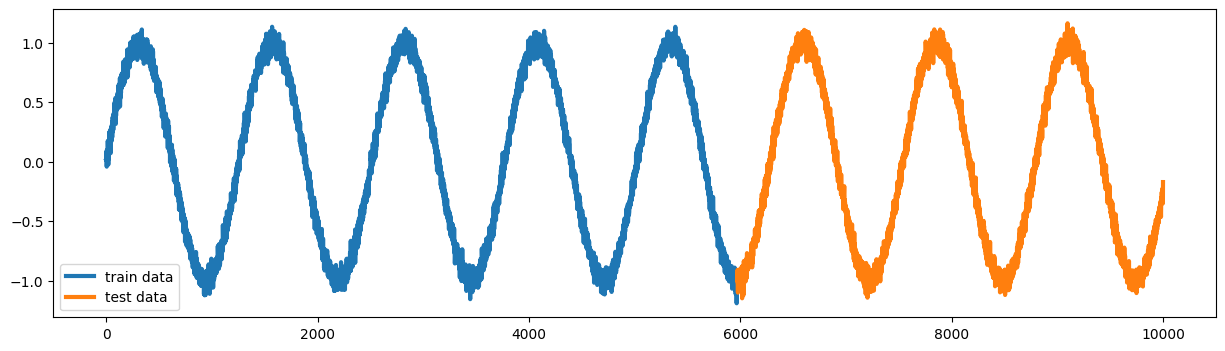

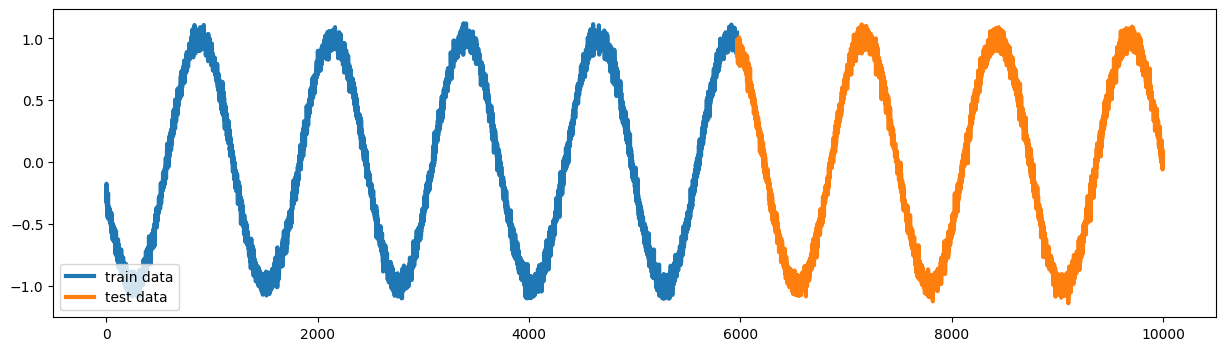

In [6]:
# Generate forward data
X_train_fwd, y_train_fwd, X_val_fwd, y_val_fwd, X_test_fwd, y_test_fwd = gen_sin_data(T, tau)
# Generate reverse data
X_train_rev, y_train_rev, X_val_rev, y_val_rev, X_test_rev, y_test_rev = gen_sin_data(T, tau, rev=True)

Create a dataset that has both forward and reverse data rather than having to do it in the model.

In [7]:
class Exp2Dataset(Dataset):
    def __init__(self, X_fwd, y_fwd, X_rev, y_rev):
        self.X_fwd = X_fwd
        self.y_fwd = y_fwd
        self.X_rev = X_rev
        self.y_rev = y_rev

        assert len(X_fwd) == len(y_fwd)
        assert len(X_rev) == len(y_rev)
        self.length = len(X_fwd)

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        return self.X_fwd[idx], self.y_fwd[idx], self.X_rev[idx], self.y_rev[idx]

In [8]:
trainset_e2 = Exp2Dataset(X_train_fwd, y_train_fwd, X_train_rev, y_train_rev)
valset_e2 = Exp2Dataset(X_val_fwd, y_val_fwd, X_val_rev, y_val_rev)
testset_e2 = Exp2Dataset(X_test_fwd, y_test_fwd, X_test_rev, y_test_rev)

train_loader_e2 = DataLoader(dataset=trainset_e2, batch_size=32, shuffle=True)
val_loader_e2 = DataLoader(dataset=valset_e2, batch_size=32, shuffle=True)
test_loader_e2 = DataLoader(dataset=testset_e2, batch_size=32, shuffle=False)

##### Model and Train

The same model from E1 is used

In [430]:
input_size = 1
hidden_size = 16
lr = .01

In [431]:
model_fwd_e2a = LSTMModel(input_size, hidden_size)
model_rev_e2a = LSTMModel(input_size, hidden_size)

In [432]:
loss_fn = nn.MSELoss()
opt_fwd_e2a = optim.Adam(model_fwd_e2a.parameters(), lr=lr)
opt_rev_e2a = optim.Adam(model_rev_e2a.parameters(), lr=lr)

In [433]:
losses_train_fwd_e2a = []
losses_val_fwd_e2a = []

losses_train_rev_e2a = []
losses_val_rev_e2a = []

losses_train_tot_e2a = []
losses_val_tot_e2a = []


In [434]:
n_epochs = 200

In [435]:

for epoch in range(n_epochs):
    # print(epoch_loss_tot)
    epoch_loss_fwd = 0.
    epoch_loss_rev = 0.
    epoch_loss_tot = 0.

    val_epoch_loss_fwd = 0.
    val_epoch_loss_rev = 0.
    val_epoch_loss_tot = 0.
    
    model_fwd_e2a.train() 
    model_rev_e2a.train() 
    
    for inputs_fwd, labels_fwd, inputs_rev, labels_rev in train_loader_e2:

        # print(labels)
        out_fwd = model_fwd_e2a(inputs_fwd)
        out_rev = model_rev_e2a(inputs_rev)
        
        # print(outputs)
        loss_fwd = loss_fn(out_fwd, labels_fwd)
        loss_rev = loss_fn(out_rev, labels_rev)
        loss_tot = loss_fwd + loss_rev

        # Backward and optimize
        opt_fwd_e2a.zero_grad()
        opt_rev_e2a.zero_grad()

        loss_tot.backward()

        opt_fwd_e2a.step()
        opt_rev_e2a.step()
        
        epoch_loss_fwd += loss_fwd.item()
        epoch_loss_rev += loss_rev.item()
        epoch_loss_tot += loss_tot.item()
       
    losses_train_fwd_e2a.append(epoch_loss_fwd / len(train_loader_e2.sampler))
    losses_train_rev_e2a.append(epoch_loss_rev / len(train_loader_e2.sampler))
    losses_train_tot_e2a.append(epoch_loss_tot / len(train_loader_e2.sampler))

    # Validation 
    model_fwd_e2a.eval()  
    model_rev_e2a.eval() 

    with torch.no_grad():
        for inputs_fwd_val, labels_fwd_val, inputs_rev_val, labels_rev_val in val_loader_e2:
            out_fwd_val = model_fwd_e2a(inputs_fwd_val)
            out_rev_val = model_fwd_e2a(inputs_rev_val)

            val_loss_fwd = loss_fn(out_fwd_val, labels_fwd_val)
            val_loss_rev = loss_fn(out_rev_val, labels_rev_val)
            val_loss_tot = val_loss_fwd + val_loss_rev

            val_epoch_loss_fwd += val_loss_fwd.item()
            val_epoch_loss_rev += val_loss_rev.item()
            val_epoch_loss_tot += val_loss_tot.item()
    
    losses_val_fwd_e2a.append(val_epoch_loss_fwd / len(val_loader_e2.sampler))
    losses_val_rev_e2a.append(val_epoch_loss_rev / len(val_loader_e2.sampler))
    losses_val_tot_e2a.append(val_epoch_loss_tot / len(val_loader_e2.sampler))

##### Loss Curves

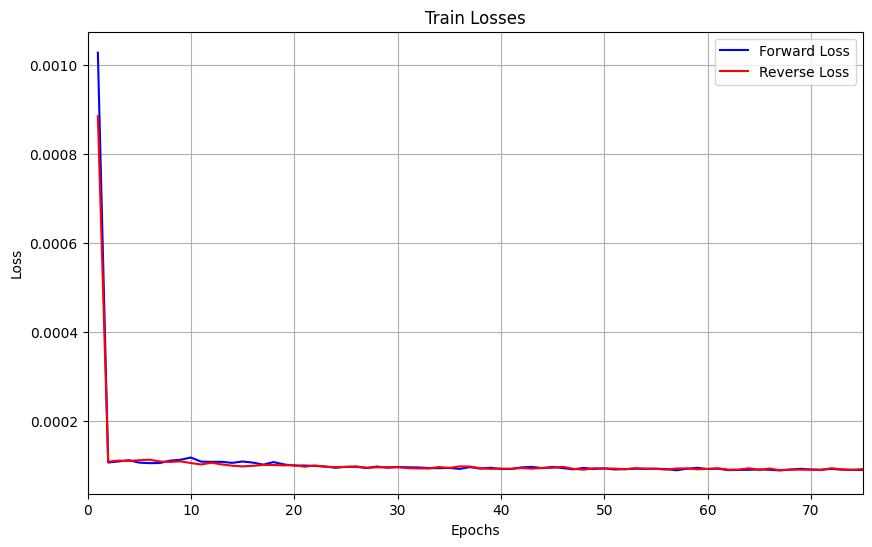

In [436]:
# train losses
epochs = range(1, len(losses_train_fwd_e2a) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, losses_train_fwd_e2a, label='Forward Loss', color='blue')
plt.plot(epochs, losses_train_rev_e2a, label='Reverse Loss', color='red')
# plt.plot(epochs, losses_train_tot_e2a, label='Total Loss', color='green')

plt.title('Train Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xlim(0, 75)
plt.legend()
plt.grid(True)
plt.show()

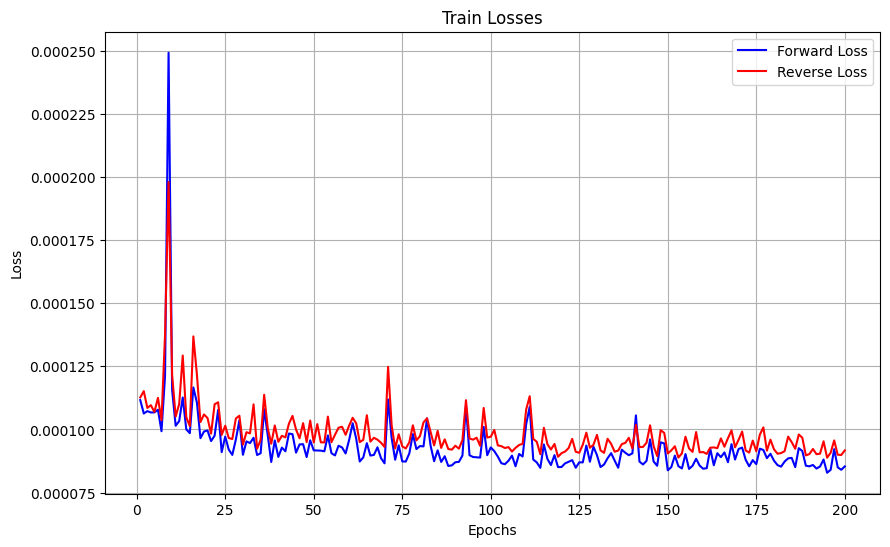

In [437]:
# val losses
epochs = range(1, len(losses_train_fwd_e2a) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, losses_val_fwd_e2a, label='Forward Loss', color='blue')
plt.plot(epochs, losses_val_rev_e2a, label='Reverse Loss', color='red')
# plt.plot(epochs, losses_val_tot_e2a, label='Total Loss', color='green')

plt.title('Train Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# plt.xlim(200, 240)
plt.legend()
plt.grid(True)
plt.show()

##### Predictions

In [438]:
preds_rev = []
true_rev = []

# eval mode
model_rev_e2a.eval()

# make preds
with torch.no_grad():
     for _, _, inputs, labels in test_loader_e2:
        
        out = model_rev_e2a(inputs)

        preds_rev.append(out.cpu().numpy())
        true_rev.append(labels.cpu().numpy())

preds_rev_e2a = np.concatenate(preds_rev).flatten()
true_rev_e2a = np.concatenate(true_rev).flatten()

In [439]:
preds_fwd = []
true_fwd = []

# eval mode
model_fwd_e2a.eval()

# make predictions
with torch.no_grad():
     for inputs, labels, _ , _ in test_loader_e2:
        
        out = model_fwd_e2a(inputs)

        preds_fwd.append(out.cpu().numpy())
        true_fwd.append(labels.cpu().numpy())

       
preds_fwd_e2a = np.concatenate(preds_fwd).flatten()
true_fwd_e2a = np.concatenate(true_fwd).flatten()

In [440]:
mae_fwd_e2a, mse_fwd_e2a = get_metrics(preds_fwd_e2a, true_fwd_e2a)
mae_rev_e2a, mse_rev_e2a = get_metrics(preds_rev_e2a, true_rev_e2a)

In [441]:
print(f"MAE Fwd: {mae_fwd_e2a}, MSE Fwd: {mse_fwd_e2a}")
print(f"MAE Rev: {mae_rev_e2a}, MSE Rev: {mse_rev_e2a}")

MAE Fwd: 0.041794419288635254, MSE Fwd: 0.0026969860773533583
MAE Rev: 0.041475892066955566, MSE Rev: 0.002735985442996025


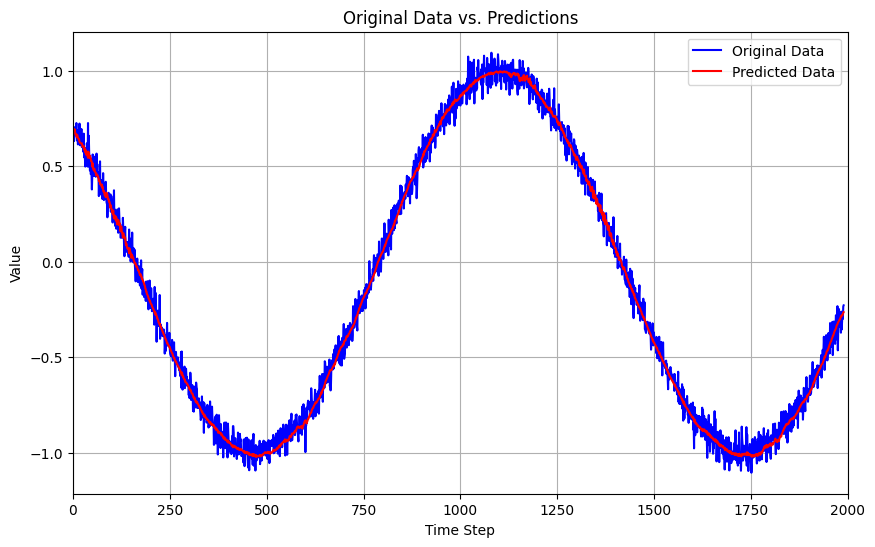

In [442]:
plt.figure(figsize=(10, 6))
plt.plot(true_fwd_e2a, label='Original Data', color='blue')
plt.plot(preds_fwd_e2a, label='Predicted Data', color='red')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Original Data vs. Predictions')
plt.legend()
plt.grid(True)
start_time_step = 0  # start
end_time_step = 2000  # end
plt.xlim(start_time_step, end_time_step)
plt.show()

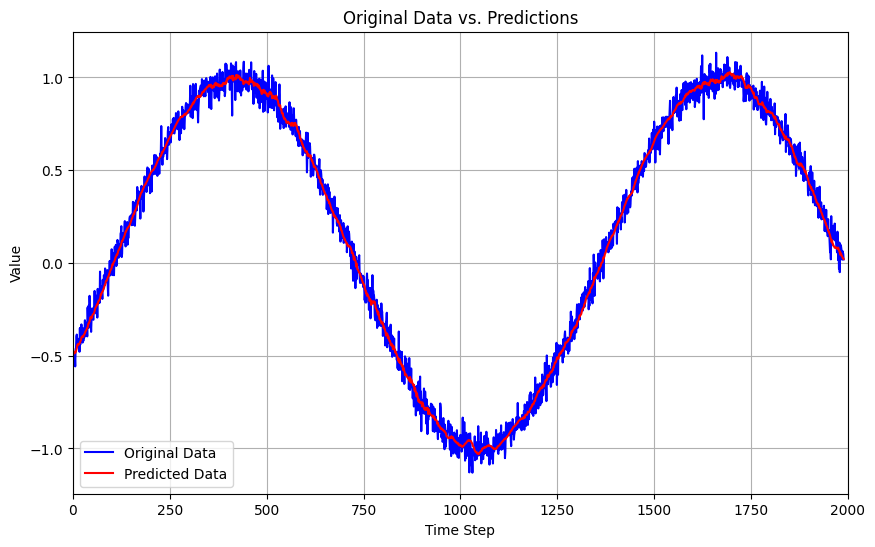

In [443]:
plt.figure(figsize=(10, 6))
plt.plot(true_rev_e2a, label='Original Data', color='blue')
plt.plot(preds_rev_e2a, label='Predicted Data', color='red')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Original Data vs. Predictions')
plt.legend()
plt.grid(True)
start_time_step = 0  
end_time_step = 2000  
plt.xlim(start_time_step, end_time_step)
plt.show()

### Running the Experiments

#### Code

In [28]:
idx = 0
for k in range(len(fwd_results)):

    fwd_result, lr, hidden_size, i = fwd_results[k]
    rev_result, lr, hidden_size, i = rev_results[k]
    
    best_model_state_dict_fwd, best_epoch_fwd, losses_train_fwd, losses_val_fwd = fwd_result
    best_model_state_dict_rev, best_epoch_rev, losses_train_rev, losses_val_rev = rev_result

    model_fwd = LSTMModel(input_size, hidden_size)
    model_rev = LSTMModel(input_size, hidden_size)

    model_fwd.load_state_dict(best_model_state_dict_fwd)
    model_rev.load_state_dict(best_model_state_dict_rev)

    preds_fwd, true_fwd = make_preds_e2(model_fwd, test_loader_e2)
    preds_rev, true_rev = make_preds_e2(model_rev, test_loader_e2, rev=True)

    mae_fwd, mse_fwd = get_metrics(preds_fwd, true_fwd)
    mae_rev, mse_rev = get_metrics(preds_rev, true_rev)
    
    # data['idx'].append(k)
    data['lr'].append(lr)
    data['hidden_size'].append(hidden_size)
    data['i'].append(i)
    data['best_epoch_fwd'].append(best_epoch_fwd)
    data['mae_fwd'].append(mae_fwd)
    data['mse_fwd'].append(mse_fwd)
    data['best_epoch_rev'].append(best_epoch_rev)
    data['mae_rev'].append(mae_rev)
    data['mse_rev'].append(mse_rev)
    data['losses_train_fwd'].append(losses_train_fwd)
    data['losses_val_fwd'].append(losses_val_fwd)
    data['losses_train_rev'].append(losses_train_rev)
    data['losses_val_rev'].append(losses_val_rev)
    

In [29]:
import pandas as pd

df = pd.DataFrame(data)

In [171]:
# lr .1 did not work. get rid of it
df = df.iloc[6:]

In [172]:
df

lr  hidden_size  i  best_epoch_fwd  best_epoch_rev   mae_fwd  \
6   0.0100            4  0              95              95  0.042099   
7   0.0100            4  1              96              96  0.042015   
8   0.0100            4  2              80              80  0.041974   
9   0.0100           16  0              90              90  0.041520   
10  0.0100           16  1              96              96  0.041579   
11  0.0100           16  2              85              85  0.041853   
12  0.0010            4  0              95              95  0.043599   
13  0.0010            4  1              88              88  0.043303   
14  0.0010            4  2              87              87  0.042656   
15  0.0010           16  0              92              92  0.042010   
16  0.0010           16  1              92              92  0.042239   
17  0.0010           16  2              58              58  0.042230   
18  0.0005            4  0              72              72  0.043434   
19  0.0005            4  1              74              74  0.043968   
20  0.0005            4  2              96              96  0.043751   
21  0.0005           16  0              95              95  0.042094   
22  0.0005           16  1              90              90  0.042381   
23  0.0005           16  2              89              89  0.043158   

     mae_rev   mse_fwd   mse_rev  \
6   0.043346  0.002770  0.002983   
7   0.043285  0.002771  0.002960   
8   0.043331  0.002762  0.002972   
9   0.042936  0.002710  0.002913   
10  0.043207  0.002729  0.002963   
11  0.043244  0.002740  0.002950   
12  0.045001  0.002980  0.003229   
13  0.044637  0.002948  0.003156   
14  0.044005  0.002839  0.003066   
15  0.043380  0.002779  0.002988   
16  0.043589  0.002814  0.003021   
17  0.043394  0.002787  0.002992   
18  0.044965  0.002962  0.003206   
19  0.045089  0.003025  0.003237   
20  0.045102  0.002997  0.003237   
21  0.043500  0.002783  0.002988   
22  0.043532  0.002812  0.003007   
23  0.044426  0.002928  0.003129   

                                     losses_train_fwd  \
6   [0.0017973924415081528, 0.00010543117635856871...   
7   [0.001442322364818754, 0.0001108658706326306, ...   
8   [0.0018211928009050874, 0.00011000436661652659...   
9   [0.000875114186349445, 0.0001100728466328377, ...   
10  [0.0008438334779632925, 0.00010754268035726306...   
11  [0.0006035353760648413, 0.00010986263234670612...   
12  [0.010036060211546656, 0.0010987215107572039, ...   
13  [0.009102326094904536, 0.001098487230713543, 0...   
14  [0.010130219617031727, 0.0012747584718905101, ...   
15  [0.0038681676323093486, 0.00012394984163440625...   
16  [0.00622029320603639, 0.00010844267829878246, ...   
17  [0.0050103308180568604, 0.00011377513289320558...   
18  [0.017450357137413282, 0.006304543397983714, 0...   
19  [0.014598397923074975, 0.006981357774218323, 0...   
20  [0.010336169216725694, 0.001095355287899374, 0...   
21  [0.007954374825429027, 0.0003430948943333385, ...   
22  [0.009120250315135548, 0.00032987485205289755,...   
23  [0.00918111806201875, 0.0002778810470784629, 0...   

                                       losses_val_fwd  \
6   [0.00010681483735466123, 0.0001047191515461958...   
7   [0.00010736052779920736, 0.0001075560521877291...   
8   [0.00012361470120841983, 0.0001055342754250832...   
9   [0.00010423580993051131, 0.0001131974791302977...   
10  [0.00014889967258102332, 0.0001078132306571918...   
11  [0.0001003573660331605, 0.000114925300828813, ...   
12  [0.0029269193154034304, 0.0004862135397878724,...   
13  [0.0031205727096328783, 0.00044142025892608726...   
14  [0.0037512391562288133, 0.0004393809584984977,...   
15  [0.0001996668029913501, 0.00010414951663445587...   
16  [0.0001708175994025253, 0.00010574567494399135...   
17  [0.00018347885352021186, 0.0001075778602290168...   
18  [0.014238791429816778, 0.0015805202278884212, ...   
19  [0.011123599681123418, 0.003006675000765815, 0...   
20  [0.00212452

In [ ]:
df['pct_diff_mae'] = ((df['mae_rev'] - df['mae_fwd']) / ((df['mae_rev'] + df['mae_fwd']) / 2)) * 100
df['pct_diff_mse'] = ((df['mse_rev'] - df['mse_fwd']) / ((df['mse_rev'] + df['mse_fwd']) / 2)) * 100

In [174]:
new_df = df[['best_epoch_fwd', 'pct_diff_mae', 'pct_diff_mse']]
new_df = new_df.rename(columns={'best_epoch_fwd': 'best_epoch'})

In [175]:
losses_df = df[['losses_train_fwd', 'losses_val_fwd', 'losses_train_rev', 'losses_val_rev', 'best_epoch_fwd']]

In [176]:
def avg_rate_of_change(arr):
    changes = [arr[i+1] - arr[i] for i in range(len(arr)-1)]
    avg_change = sum(changes) / len(changes)
    return avg_change * 1000 # because values are small, for readability

In [ ]:
losses_df['rate_train_fw'] = losses_df['losses_train_fwd'].apply(avg_rate_of_change)
losses_df['rate_train_rev'] = losses_df['losses_train_rev'].apply(avg_rate_of_change)
losses_df['rate_val_fw'] = losses_df['losses_val_fwd'].apply(avg_rate_of_change)
losses_df['rate_val_rev'] = losses_df['losses_val_rev'].apply(avg_rate_of_change)

In [ ]:
losses_df['pct_diff_val'] = ((losses_df['rate_val_rev'] - losses_df['rate_val_fw']) / ((losses_df['rate_val_rev'] + losses_df['rate_val_fw']) / 2)) * 100

In [179]:
losses_df_res = losses_df[['rate_val_fw', 'rate_val_rev', 'pct_diff_val']]

#### Results

Examining the loss curves, it does appear that we are seeing the loss for the reverse predictions be reduced at a faster rate.  Additionally, examining the errors for both the forward and reverse, the reverse has better results in both metrics in all but one model.  This is interesting, 

In [ ]:
losses_df_res

index: 0


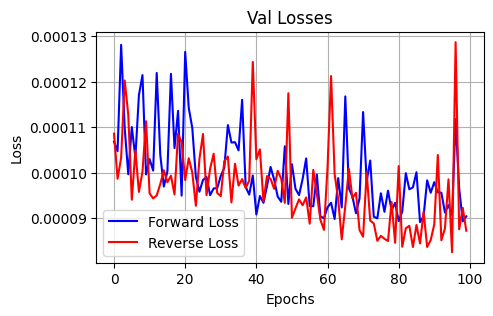

index: 1


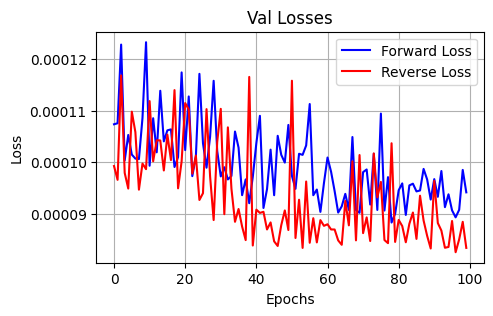

index: 2


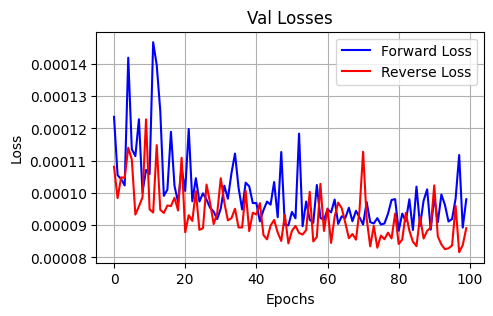

index: 3


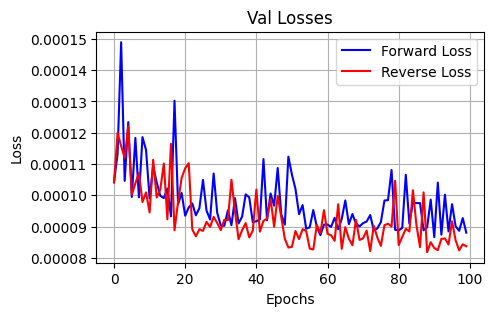

index: 4


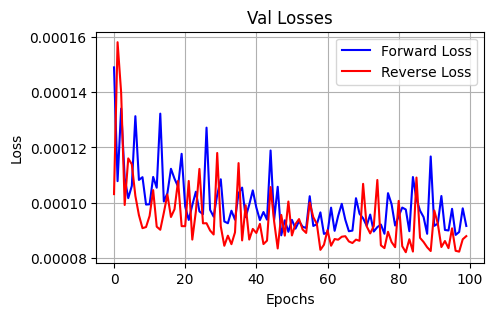

index: 5


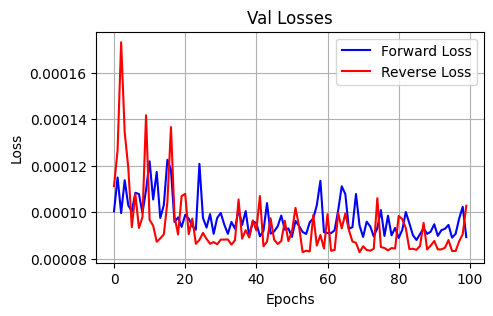

index: 6


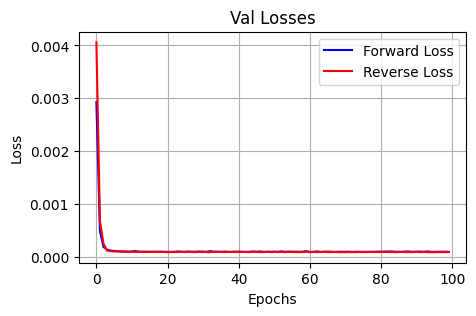

index: 7


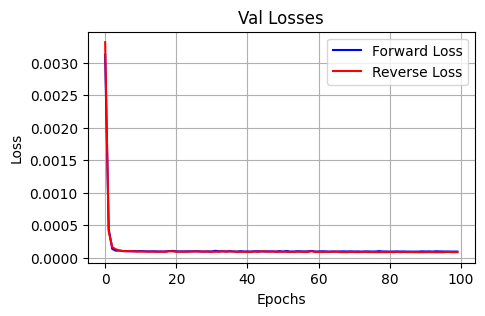

index: 8


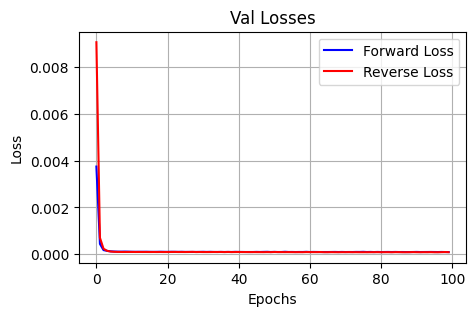

index: 9


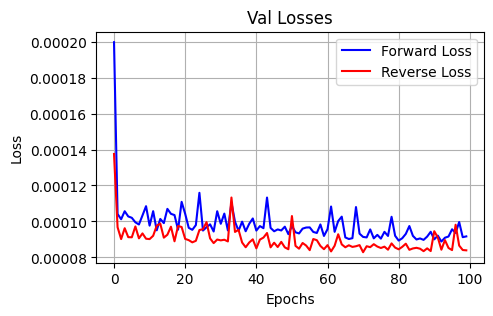

index: 10


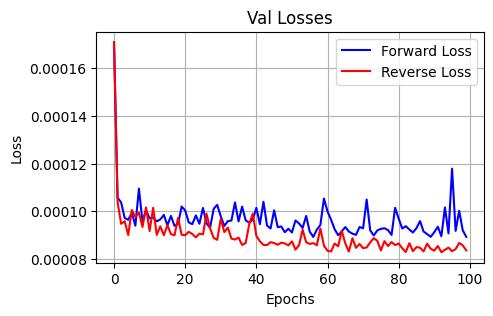

index: 11


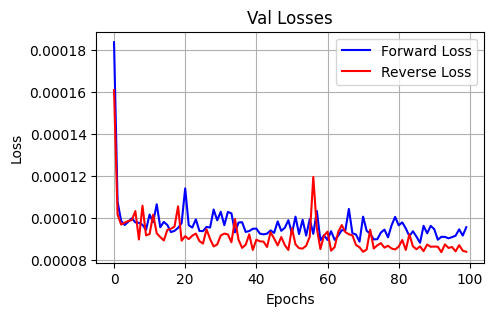

index: 12


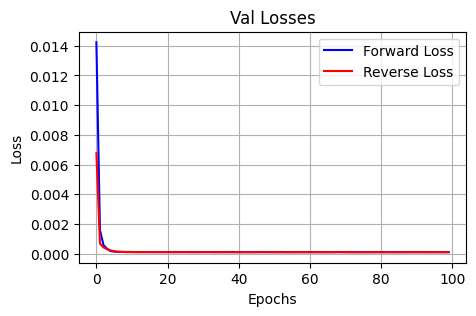

index: 13


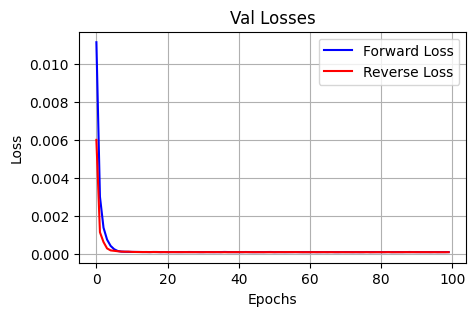

index: 14


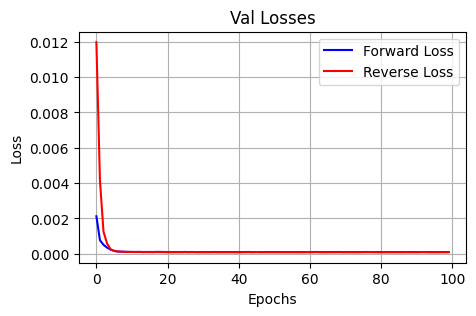

index: 15


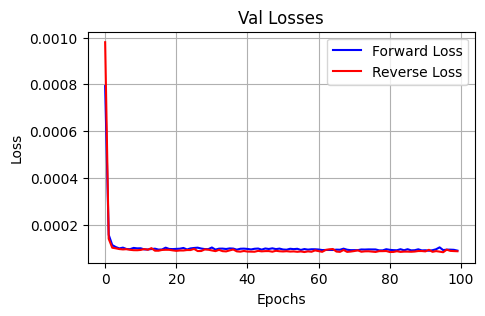

index: 16


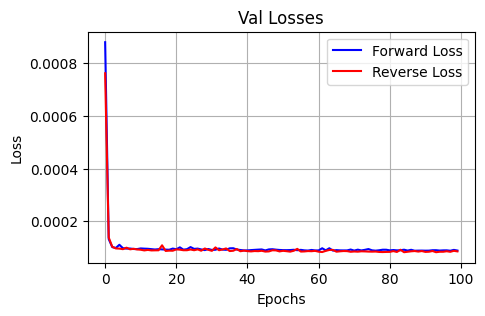

index: 17


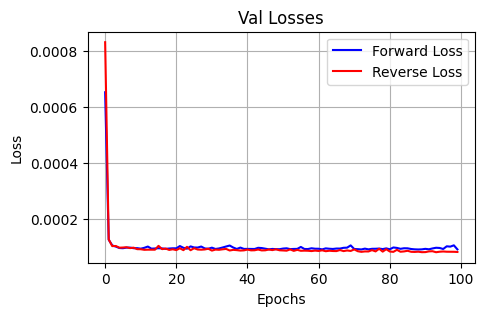

In [181]:

for i in range (18):

    plt.figure(figsize=(5, 3))

    print(f'index: {i}')
    plt.plot(losses_df.iloc[i][1], label='Forward Loss', color='blue')
    plt.plot(losses_df.iloc[i][3], label='Reverse Loss', color='red')

    plt.title('Val Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    # plt.xlim(0, 50)
    plt.show()

In [123]:
new_df

best_epoch  pct_diff_mae  pct_diff_mse
0           27      3.541708      7.607897
1           85      0.439889      3.421755
2           81      2.756183      7.090052
3           32      4.547400      9.608206
4           10      2.372273      6.135717
5           21     -0.035420      1.606387
6           95      2.918269      7.401064
7           96      2.976949      6.601006
8           80      3.182865      7.302908
9           90      3.354174      7.200626
10          96      3.840038      8.224423
11          85      3.268761      7.390635
12          95      3.164483      8.035290
13          88      3.034265      6.820915
14          87      3.112336      7.678522
15          92      3.209719      7.262878
16          92      3.146190      7.085028
17          58      2.719921      7.118302
18          72      3.462315      7.889669
19          74      2.517526      6.768384
20          96      3.040305      7.682314
21          95      3.284884      7.103463
22          90      2.678981      6.720123
23          89      2.895337      6.642714

### Experiment 2A w/ Finance Data

#### Data

In [7]:
from data_utils import *

In [8]:
train_loader_fin, val_loader_fin, test_loader_fin = get_stock_data_e2a(125)

[*********************100%%**********************]  1 of 1 completed


#### Running the Experiment

In [9]:
lrs = [.005, .001, .0005]
hiddens = [4, 8, 16]
num_runs = 2

In [10]:
fwd_results_fin = []
rev_results_fin = []

In [ ]:
for lr in lrs:
    for hidden_size in hiddens:
        for i in range(num_runs):

            model_fwd = LSTMModel(1, hidden_size)
            model_rev = LSTMModel(1, hidden_size)

            loss_fn = nn.MSELoss()

            opt_fwd = optim.Adam(model_fwd.parameters(), lr=lr)
            opt_rev = optim.Adam(model_rev.parameters(), lr=lr)

            fwd_result, rev_result = train_e2a_model(model_fwd, model_rev, train_loader_fin, val_loader_fin, loss_fn, opt_fwd, opt_rev, n_epochs=50)

            fwd_results_fin.append((fwd_result, lr, hidden_size, i))
            rev_results_fin.append((rev_result, lr, hidden_size, i))

##### Results -- Code

In [37]:
data_e2fin = {
    'lr': [],
    'hidden_size': [],
    'best_epoch': [],
    'mae_fwd': [],
    'mae_rev': [],
    'mse_fwd': [],
    'mse_rev': []
}

losses_e2fin = {
    'train_fwd': [],
    'train_rev': [],
    'val_fwd': [],
    'val_rev': []

}

e3_e2fin = {
    'abs_error_fwd': [],
    'abs_error_rev': [],
    'sq_error_fwd': [],
    'sq_error_rev': [],
    'pct_error_fwd': [],
    'pct_error_rev': [],

}

In [38]:
for k in range(len(fwd_results_fin)):

    fwd_result, lr, hidden_size, i = fwd_results_fin[k]
    rev_result, lr, hidden_size, i = rev_results_fin[k]
    
    best_model_state_dict_fwd, best_epoch_fwd, losses_train_fwd, losses_val_fwd = fwd_result
    best_model_state_dict_rev, best_epoch_rev, losses_train_rev, losses_val_rev = rev_result

    model_fwd = LSTMModel(1, hidden_size)
    model_rev = LSTMModel(1, hidden_size)

    model_fwd.load_state_dict(best_model_state_dict_fwd)
    model_rev.load_state_dict(best_model_state_dict_rev)

    preds_fwd, true_fwd = make_preds_e2(model_fwd, test_loader_fin)
    preds_rev, true_rev = make_preds_e2(model_rev, test_loader_fin, rev=True)

    mae_fwd, mse_fwd = get_metrics(preds_fwd, true_fwd)
    mae_rev, mse_rev = get_metrics(preds_rev, true_rev)

    abs_error_fwd = np.abs(true_fwd - preds_fwd)
    abs_error_rev = np.abs(true_rev - preds_rev)

    sq_error_fwd = (true_fwd - preds_fwd) ** 2
    sq_error_rev = (true_rev - preds_rev) ** 2

    pct_error_fwd = np.abs((true_fwd - preds_fwd) / true_fwd) * 100
    pct_error_rev = np.abs((true_rev - preds_rev) / true_rev) * 100
        
    data_e2fin['lr'].append(lr)
    data_e2fin['hidden_size'].append(hidden_size)
    data_e2fin['best_epoch'].append(best_epoch_fwd)
    data_e2fin['mae_fwd'].append(mae_fwd)
    data_e2fin['mse_fwd'].append(mse_fwd)
    data_e2fin['mae_rev'].append(mae_rev)
    data_e2fin['mse_rev'].append(mse_rev)

    losses_e2fin['train_fwd'].append(losses_train_fwd)
    losses_e2fin['val_fwd'].append(losses_val_fwd)
    losses_e2fin['train_rev'].append(losses_train_rev)
    losses_e2fin['val_rev'].append(losses_val_rev)

    e3_e2fin['abs_error_fwd'].append(abs_error_fwd)
    e3_e2fin['abs_error_rev'].append(abs_error_rev)
    e3_e2fin['sq_error_fwd'].append(sq_error_fwd)
    e3_e2fin['sq_error_rev'].append(sq_error_rev)
    e3_e2fin['pct_error_fwd'].append(pct_error_fwd)
    e3_e2fin['pct_error_rev'].append(pct_error_rev)


    

In [21]:
import pandas as pd

df_fin = pd.DataFrame(data_e2fin)

In [22]:
df_fin.head()

lr  hidden_size  best_epoch   mae_fwd   mae_rev   mse_fwd   mse_rev
0  0.005            4          45  0.049942  0.049685  0.005935  0.006020
1  0.005            4          45  0.049942  0.049685  0.005935  0.006020
2  0.005            4          37  0.050002  0.049631  0.006019  0.006002
3  0.005            8           1  0.049769  0.049698  0.005907  0.005924
4  0.005            8           6  0.049950  0.049658  0.005969  0.005941

In [23]:
df['pct_diff_mae'] = ((df['mae_rev'] - df['mae_fwd']) / ((df['mae_rev'] + df['mae_fwd']) / 2)) * 100
df['pct_diff_mse'] = ((df['mse_rev'] - df['mse_fwd']) / ((df['mse_rev'] + df['mse_fwd']) / 2)) * 100

In [25]:
new_df_fin = df[['best_epoch', 'pct_diff_mae', 'pct_diff_mse']]


In [29]:
losses_e2fin_df = pd.DataFrame(losses_e2fin)

In [30]:
losses_e2fin_df.head()

train_fwd  \
0  [0.00015887828770509642, 0.0001549306186022481...   
1  [0.000165040797413363, 0.00015479868880656738,...   
2  [0.00017189415118096555, 0.0001545079099599686...   
3  [0.0007696475969553133, 0.0001560987595030328,...   
4  [0.0001587669879751685, 0.00015439355495772803...   

                                           train_rev  \
0  [0.0012392486815837463, 0.0001556391235654301,...   
1  [0.0010656357094118933, 0.00015511766220312122...   
2  [0.00020990562252149472, 0.0001559297480862194...   
3  [0.00022322032245401593, 0.0001549441662064544...   
4  [0.00026772687700705403, 0.0001560648717681009...   

                                             val_fwd  \
0  [0.000243802142910765, 0.00024821152358868, 0....   
1  [0.00024642105171364463, 0.0002473199378810186...   
2  [0.0002458046251052387, 0.0002457835923485585,...   
3  [0.00026167947550303843, 0.0002549993626374718...   
4  [0.00025117308406285947, 0.0002472434678761087...   

                                             val_rev  
0  [0.00025955634716156873, 0.0002590934977146751...  
1  [0.0002506502957810237, 0.000249583269512179, ...  
2  [0.0002481366246320932, 0.0002477165837750821,...  
3  [0.00024771747745815965, 0.0002474991178655244...  
4  [0.0002493696733314542, 0.00025724555785555203...

##### Results -- Output

In [31]:
new_df_fin

best_epoch  pct_diff_mae  pct_diff_mse
0           45     -0.515361      1.423081
1           45     -0.515361      1.423081
2           37     -0.745123     -0.282515
3            1     -0.143654      0.290109
4            6     -0.587205     -0.475038
5           45     -1.222441     -2.157405
6           41     -1.746198      1.491207
7           13     -0.945943     -1.401800
8           19     -0.376725     -0.248516
9            4     -0.985421     -0.628629
10          21     -0.612989      0.048904
11           3     -0.665629     -0.981791
12          17     -0.767064     -1.131656
13          40     -0.541430     -0.798191
14           2     -0.914151     -1.469059
15          15     -0.803342     -1.177989
16          46     -0.743343     -0.270274
17          35     -0.523599     -0.414345
18          37     -0.463647     -0.560580

In [32]:
max_pct_diff_mae = new_df_fin['pct_diff_mae'].max()
min_pct_diff_mae = new_df_fin['pct_diff_mae'].min()
avg_pct_diff_mae = new_df_fin['pct_diff_mae'].mean()

max_pct_diff_mse = new_df_fin['pct_diff_mse'].max()
min_pct_diff_mse = new_df_fin['pct_diff_mse'].min()
avg_pct_diff_mse = new_df_fin['pct_diff_mse'].mean()

print("Maximum pct_diff_mae:", max_pct_diff_mae)
print("Minimum pct_diff_mae:", min_pct_diff_mae)
print("Avg pct_diff_mae:", avg_pct_diff_mae)
print()
print("Maximum pct_diff_mse:", max_pct_diff_mse)
print("Minimum pct_diff_mse:", min_pct_diff_mse)
print("Avg pct_diff_mse:", avg_pct_diff_mse)

Maximum pct_diff_mae: -0.14365366
Minimum pct_diff_mae: -1.7461982
Avg pct_diff_mae: -0.72729605

Maximum pct_diff_mse: 1.491207
Minimum pct_diff_mse: -2.1574051
Avg pct_diff_mse: -0.3853371


index: 0


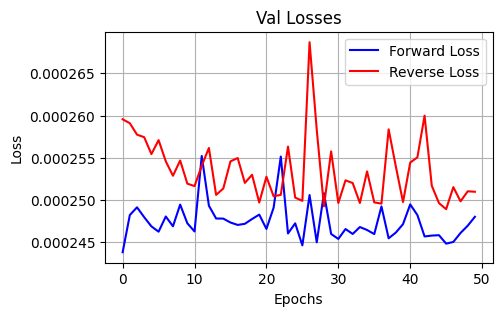

index: 1


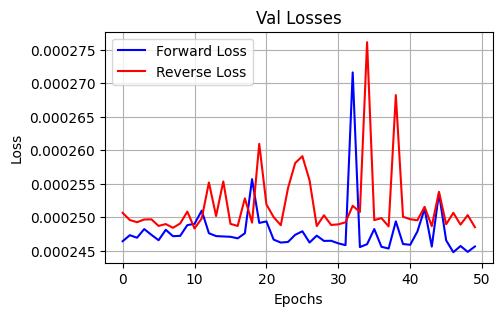

index: 2


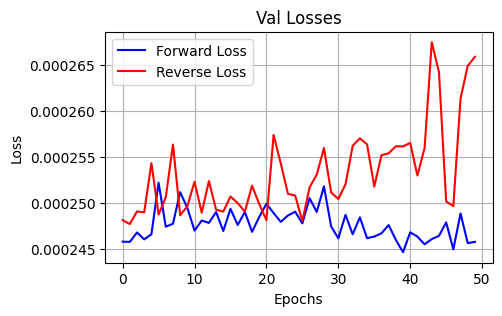

index: 3


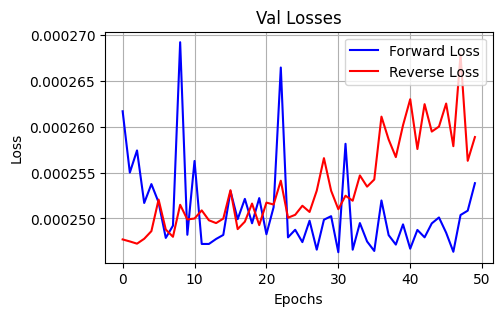

index: 4


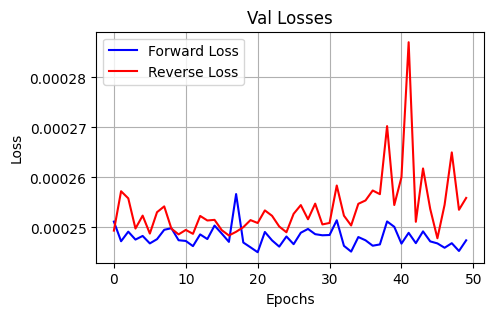

index: 5


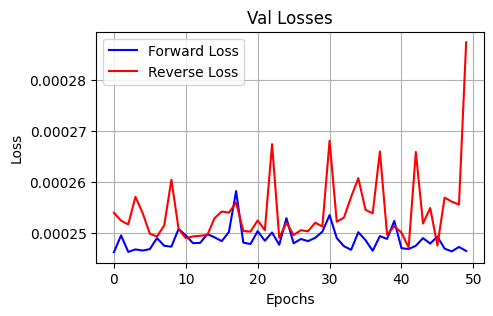

index: 6


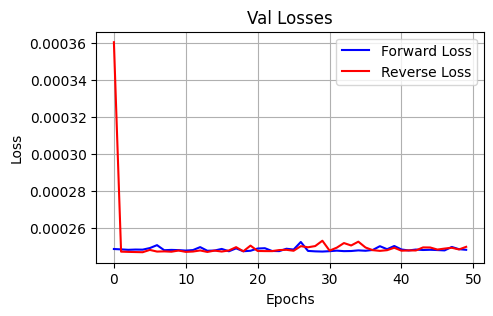

index: 7


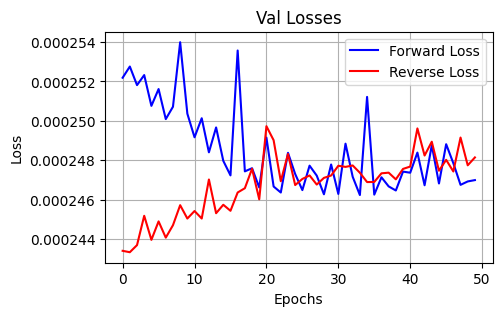

index: 8


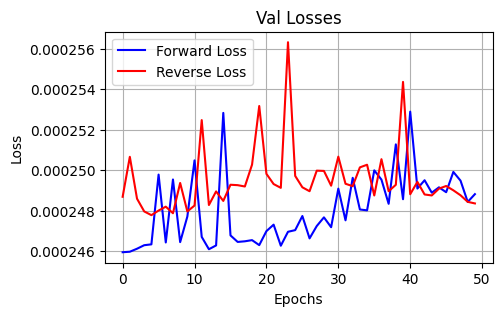

index: 9


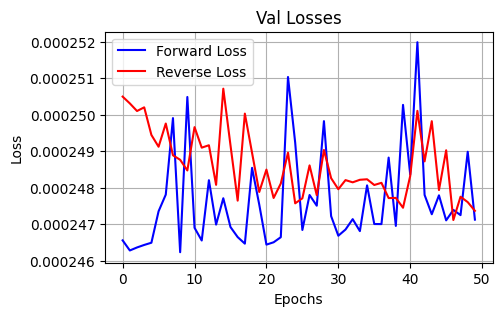

index: 10


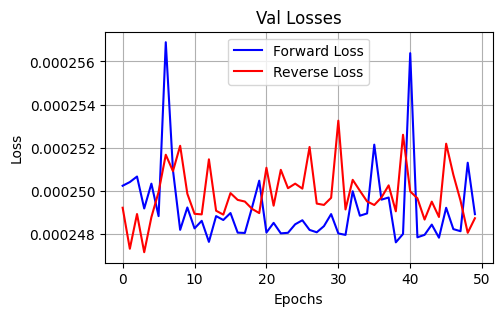

index: 11


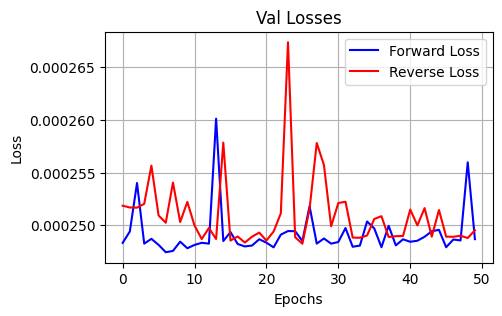

index: 12


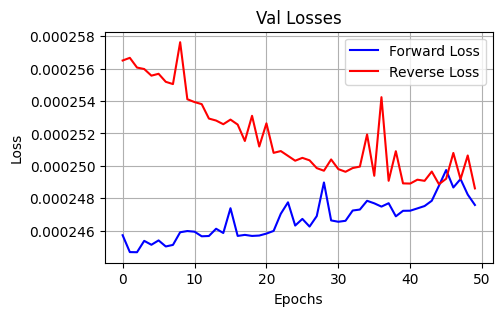

index: 13


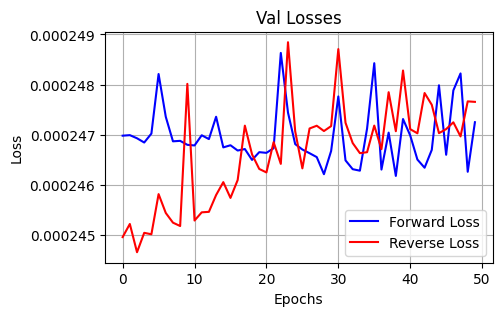

index: 14


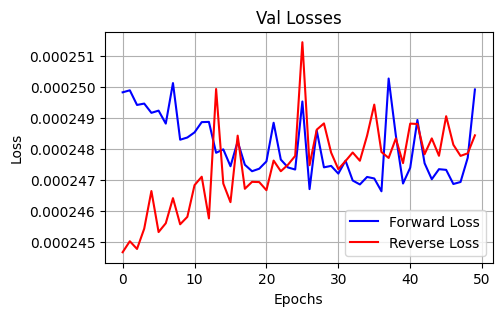

index: 15


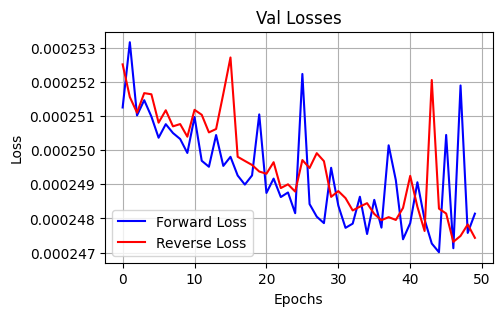

index: 16


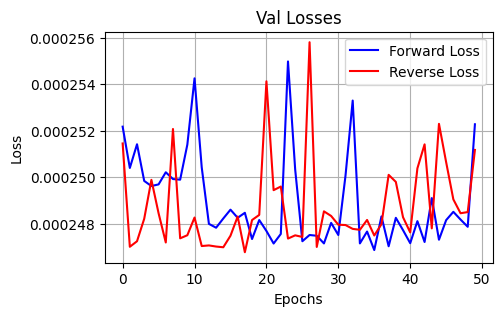

index: 17


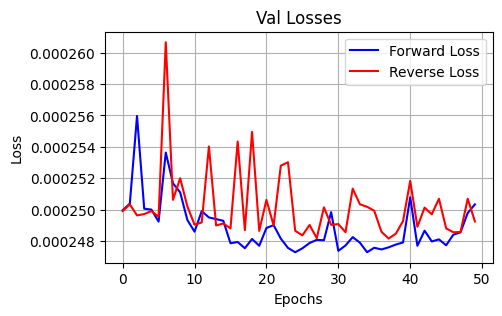

In [36]:
for i in range (18):

    plt.figure(figsize=(5, 3))

    print(f'index: {i}')
    plt.plot(losses_e2fin_df.iloc[i][2], label='Forward Loss', color='blue')
    plt.plot(losses_e2fin_df.iloc[i][3], label='Reverse Loss', color='red')

    plt.title('Val Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    # plt.xlim(0, 50)
    plt.show()

### 2-B1

##### Data

In [6]:
T = 12000
n_train = 10000
tau = 100

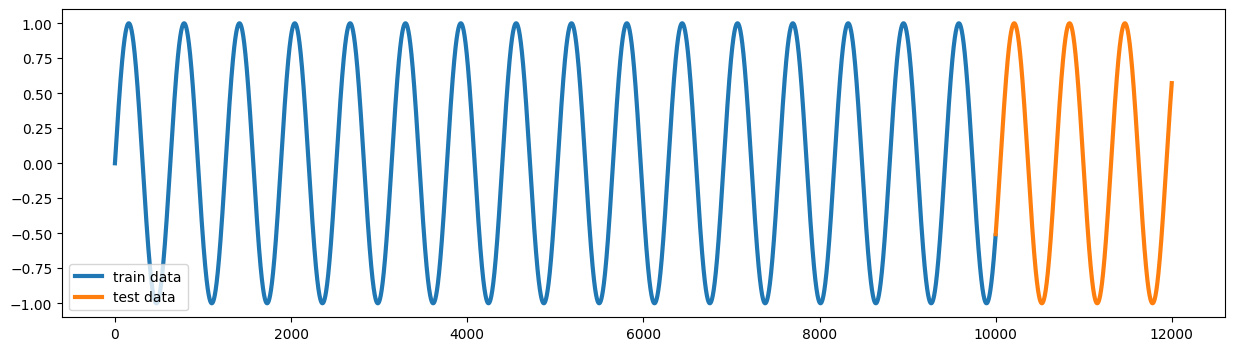

In [7]:
X_train, y_train, X_test, y_test = get_e2_sin_data(T, n_train, tau)

In [8]:
pct = .8
idx = int(n_train * pct)

X_val = X_train[idx:]
X_train = X_train[:idx]

y_val = y_train[idx:]
y_train = y_train[:idx]


In [9]:
X_train.shape

torch.Size([8000, 100, 1])

In [10]:
trainset_e2b = TensorDataset(X_train, y_train)
valset_e2b = TensorDataset(X_val, y_val)
testset_e2b = TensorDataset(X_test, y_test)

train_loader_e2b = DataLoader(dataset=trainset_e2b, batch_size=32, shuffle=True)
val_loader_e2b = DataLoader(dataset=valset_e2b, batch_size=32, shuffle=True)
test_loader_e2b = DataLoader(dataset=testset_e2b, batch_size=32, shuffle=False)

##### Model and Train

In [11]:
class LSTM_B1(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM_B1, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        
        self.lstm_forward = nn.LSTM(input_size, hidden_size,  batch_first=True)
        self.lstm_backward = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size * 2, output_size) 
        
    def forward(self, x): 
        # Forward LSTM
        out_forward, _ = self.lstm_forward(x)
        
        # Backward LSTM 
        out_backward, _ = self.lstm_backward(torch.flip(x, [1]))
        
        # Concatenate the outputs of forward and backward LSTMs
        out_cat = torch.cat((out_forward[:, -1, :], out_backward[:, -1, :]), dim=1)
        
        # Fully connected layer
        out = self.fc(out_cat)
        
        return out

In [136]:
input_size = 1
hidden_size = 8
lr = .001
n_epochs = 50

In [134]:
e2b1_net = LSTM_B1(input_size, hidden_size, 2)

In [135]:
loss_fn = nn.MSELoss()
opt = optim.Adam(e2b1_net.parameters(), lr=lr)

In [137]:
losses_fwd_train = []
losses_rev_train = []
losses_tot_train = []

losses_fwd_val = []
losses_rev_val = []
losses_tot_val = []

for epoch in range(n_epochs):
    # print(epoch_loss_tot)
    epoch_loss_fwd = 0.
    epoch_loss_rev = 0.
    epoch_loss_tot = 0.


    tot_val_fwd = 0.
    tot_val_rev = 0.
    tot_val_tot = 0.
    
    e2b1_net.train()
    for inputs, labels in train_loader_e2b:

        out = e2b1_net(inputs)
        out_fwd = out[:, 0:1]
        out_rev = out[:, 1:2]
        
        labels_fwd = labels[:, 1, :]
        labels_rev = labels[:, 0, :]
        
        loss_fwd = loss_fn(out_fwd, labels_fwd)
        loss_rev = loss_fn(out_rev, labels_rev)
        loss_tot = loss_fwd + loss_rev

        opt.zero_grad()
        loss_tot.backward()
        opt.step()
        
        epoch_loss_fwd += loss_fwd.item()
        epoch_loss_rev += loss_rev.item()
        epoch_loss_tot += loss_tot.item()
       
    losses_fwd_train.append(epoch_loss_fwd / (len(train_loader_e2b.sampler)))
    losses_rev_train.append(epoch_loss_rev / (len(train_loader_e2b.sampler)))
    losses_tot_train.append(epoch_loss_tot / (len(train_loader_e2b.sampler)))
     
    # validation 
    e2b1_net.eval()  
    with torch.no_grad():
        for inputs_val, labels_val in val_loader_e2b:
           
            out_val = e2b1_net(inputs_val)

            out_fwd_val = out_val[:, 0:1]
            out_rev_val = out_val[:, 1:2]
            
            labels_fwd_val = labels_val[:, 1, :]
            labels_rev_val = labels_val[:, 0, :]

            val_loss_fwd = loss_fn(out_fwd_val, labels_fwd_val)
            val_loss_rev = loss_fn(out_rev_val, labels_rev_val)
            val_loss_tot = val_loss_rev + val_loss_fwd

            tot_val_fwd += val_loss_fwd.item()
            tot_val_rev += val_loss_rev.item()
            tot_val_tot += val_loss_tot.item()
    
    losses_fwd_val.append(tot_val_fwd / (len(val_loader_e2b.sampler)))
    losses_rev_val.append(tot_val_rev / (len(val_loader_e2b.sampler)))
    losses_tot_val.append(tot_val_tot / (len(val_loader_e2b.sampler)))

##### Loss Curve

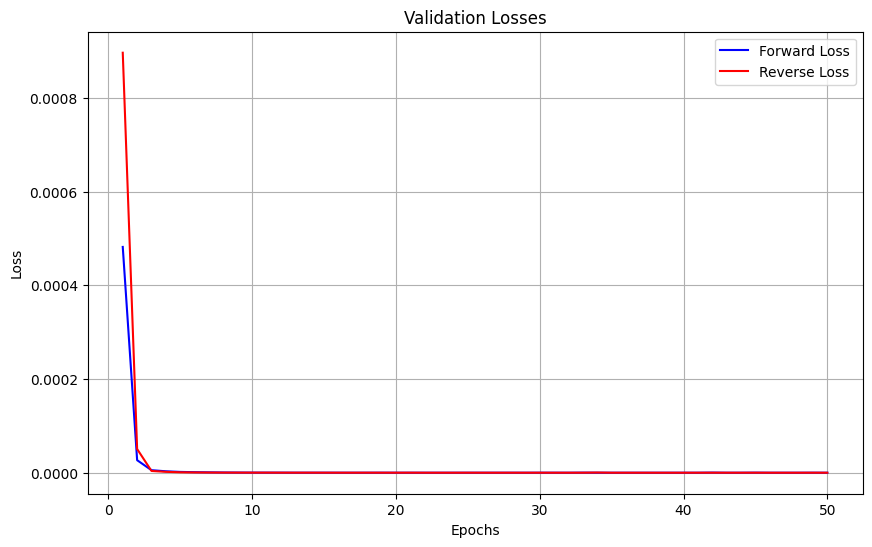

In [138]:
epochs = range(1, len(losses_tot_val) + 1)

plt.figure(figsize=(10, 6))

plt.plot(epochs, losses_fwd_val, label='Forward Loss', color='blue')
plt.plot(epochs, losses_rev_val, label='Reverse Loss', color='red')

plt.title('Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

#### Running the Experiment

In [19]:
lrs = [.005, .001, .0005]
hiddens = [4, 8, 16]
num_runs = 3

In [20]:
results = []

In [21]:
for lr in lrs:
    for hidden_size in hiddens:
        for i in range(num_runs):

            model = LSTM_B1(1, hidden_size, 2)
            loss_fn = nn.MSELoss()
            opt = optim.Adam(model.parameters(), lr=lr)
            result = train_model_e2b1(model, train_loader_e2b, val_loader_e2b, loss_fn, opt)
            results.append((result, lr, hidden_size, i))



/Users/kevinkaplan/tensorflow-test/env/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


#### Results - Code

In [33]:
import pandas as pd

In [28]:
def make_preds_e2b1(model, test_loader):
    preds_fwd = []
    true_fwd = []

    preds_rev = []
    true_rev = []

    # eval mode
    model.eval()
    # make preds
    with torch.no_grad():
        for inputs, labels in test_loader:
            
            out = model(inputs)

            out_fwd = out[:, 0:1]
            out_rev = out[:, 1:2]
                
            labels_fwd = labels[:, 1, :]
            labels_rev = labels[:, 0, :]

            preds_fwd.append(out_fwd.cpu().numpy())
            true_fwd.append(labels_fwd.cpu().numpy())

            preds_rev.append(out_rev.cpu().numpy())
            true_rev.append(labels_rev.cpu().numpy())

    preds_fwd = np.concatenate(preds_fwd).flatten()
    true_fwd = np.concatenate(true_fwd).flatten()

    preds_rev = np.concatenate(preds_rev).flatten()
    true_rev = np.concatenate(true_rev).flatten()

    return preds_fwd, true_fwd, preds_rev, true_rev

In [101]:
data_e2b1 = {
    'lr': [],
    'hidden_size': [],
    'best_epoch': [],
    'mae_fwd': [],
    'mae_rev': [],
    'mse_fwd': [],
    'mse_rev': []
}

losses_e2b1 = {
    'train_fwd': [],
    'train_rev': [],
    'val_fwd': [],
    'val_rev': []

}

In [102]:
for item in results:
    result, lr, hidden_size, i = item
    best_model_state_dict, best_epoch, losses_fwd_train, losses_fwd_val, losses_rev_train, losses_rev_val = result

    model = LSTM_B1(1, hidden_size, 2)

    model.load_state_dict(best_model_state_dict)

    preds_fwd, true_fwd, preds_rev, true_rev = make_preds_e2b1(model, test_loader_e2b)
    
    mae_fwd, mse_fwd = get_metrics(preds_fwd, true_fwd)
    mae_rev, mse_rev = get_metrics(preds_rev, true_rev)
    
    data_e2b1['lr'].append(lr)
    data_e2b1['hidden_size'].append(hidden_size)
    data_e2b1['best_epoch'].append(best_epoch)

    data_e2b1['mae_fwd'].append(mae_fwd)
    data_e2b1['mse_fwd'].append(mse_fwd)
    data_e2b1['mae_rev'].append(mae_rev)
    data_e2b1['mse_rev'].append(mse_rev)
    
    losses_e2b1['train_fwd'].append(losses_fwd_train)
    losses_e2b1['train_rev'].append(losses_rev_train)
    losses_e2b1['val_fwd'].append(losses_fwd_val)
    losses_e2b1['val_rev'].append(losses_rev_val)
    

In [103]:
print(len(data_e2b1['lr']),
len(data_e2b1['hidden_size']),
len(data_e2b1['best_epoch']),
len(data_e2b1['mae_fwd']),
len(data_e2b1['mse_fwd']),
len(data_e2b1['mae_rev']),
len(data_e2b1['mse_rev']))

27 27 27 27 27 27 27


In [106]:
df = pd.DataFrame(data_e2b1)

In [107]:
df.head()

lr  hidden_size  best_epoch   mae_fwd   mae_rev       mse_fwd  \
0  0.005            4          85  0.000262  0.000359  1.123160e-07   
1  0.005            4          96  0.000142  0.000209  3.139638e-08   
2  0.005            4          59  0.000213  0.000236  7.379844e-08   
3  0.005            8          85  0.000109  0.000153  1.783173e-08   
4  0.005            8          80  0.000232  0.000163  8.013474e-08   

        mse_rev  
0  1.709469e-07  
1  8.002257e-08  
2  7.885019e-08  
3  3.616899e-08  
4  4.155502e-08

In [108]:
df['pct_diff_mae'] = ((df['mae_rev'] - df['mae_fwd']) / df['mae_fwd']) * 100
df['pct_diff_mse'] = ((df['mse_rev'] - df['mse_fwd']) / df['mse_fwd']) * 100

In [109]:
df.head()

lr  hidden_size  best_epoch   mae_fwd   mae_rev       mse_fwd  \
0  0.005            4          85  0.000262  0.000359  1.123160e-07   
1  0.005            4          96  0.000142  0.000209  3.139638e-08   
2  0.005            4          59  0.000213  0.000236  7.379844e-08   
3  0.005            8          85  0.000109  0.000153  1.783173e-08   
4  0.005            8          80  0.000232  0.000163  8.013474e-08   

        mse_rev  pct_diff_mae  pct_diff_mse  
0  1.709469e-07     37.313522     52.201687  
1  8.002257e-08     47.116741    154.878326  
2  7.885019e-08     10.616153      6.845329  
3  3.616899e-08     40.394100    102.835045  
4  4.155502e-08    -29.658001    -48.143559

In [114]:
results = df[['pct_diff_mae', 'pct_diff_mse']]

In [105]:
losses_df = pd.DataFrame(losses_e2b1)

In [116]:
losses_df.head(2)

train_fwd  \
0  [0.0019086425546192914, 6.838789412995539e-06,...   
1  [0.002156435992943443, 5.199425866976526e-06, ...   

                                           train_rev  \
0  [0.0016442098862353306, 7.962787844007834e-06,...   
1  [0.0036034217041305966, 9.30207651163073e-06, ...   

                                             val_fwd  \
0  [2.2777793943532743e-05, 1.3948974701634142e-0...   
1  [1.8514560142648406e-05, 1.894058812467847e-06...   

                                             val_rev  
0  [1.594204767025076e-05, 4.035833961097523e-06,...  
1  [3.872627843520604e-05, 2.2035927413526226e-06...

#### Results - Output

In [115]:
results

pct_diff_mae  pct_diff_mse
0      37.313522     52.201687
1      47.116741    154.878326
2      10.616153      6.845329
3      40.394100    102.835045
4     -29.658001    -48.143559
5     -35.665379    -57.639790
6     -45.454117    -69.099609
7       2.591243     -8.299809
8      36.911762     91.796211
9       0.980642     14.040555
10    -41.009693    -60.778988
11     18.433044     50.791698
12    -15.734302    -27.600029
13    -27.813444    -42.454929
14    -37.231998    -56.997425
15     22.666668     45.885254
16    -17.938692    -36.782925
17    -25.268385    -44.983662
18    -50.307129    -72.822311
19     -7.996919    -21.752815
20     12.949991     33.302235
21      5.105389     19.078482
22     30.672615     66.891724
23     52.739555    125.445900
24     -6.699280    -15.181342
25      1.715650      8.414000
26     45.673862    107.176079

In [112]:
max_pct_diff_mae = df['pct_diff_mae'].max()
min_pct_diff_mae = df['pct_diff_mae'].min()
avg_pct_diff_mae = df['pct_diff_mae'].mean()

max_pct_diff_mse = df['pct_diff_mse'].max()
min_pct_diff_mse = df['pct_diff_mse'].min()
avg_pct_diff_mse = df['pct_diff_mse'].mean()

print("Maximum pct_diff_mae:", max_pct_diff_mae)
print("Minimum pct_diff_mae:", min_pct_diff_mae)
print("Avg pct_diff_mae:", avg_pct_diff_mae)
print()
print("Maximum pct_diff_mse:", max_pct_diff_mse)
print("Minimum pct_diff_mse:", min_pct_diff_mse)
print("Avg pct_diff_mse:", avg_pct_diff_mse)

Maximum pct_diff_mae: 52.739555
Minimum pct_diff_mae: -50.30713
Avg pct_diff_mae: 0.9297629

Maximum pct_diff_mse: 154.87833
Minimum pct_diff_mse: -72.82231
Avg pct_diff_mse: 11.74242


index: 0


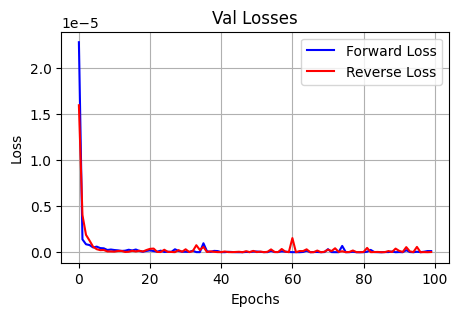

index: 1


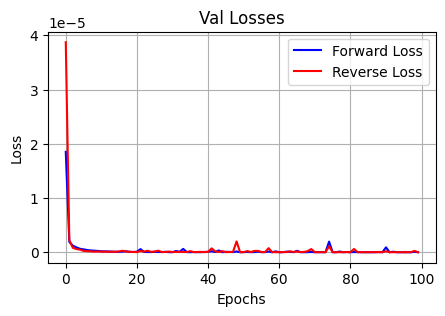

index: 2


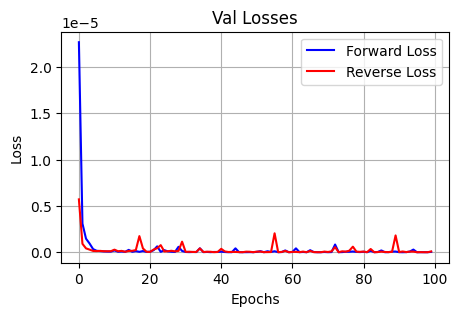

index: 3


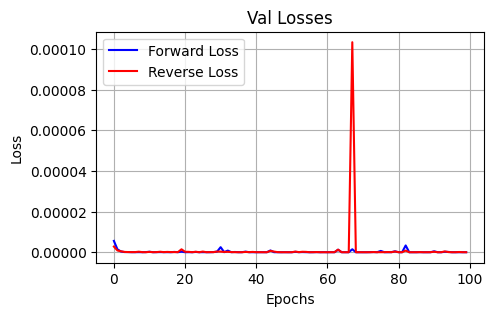

index: 4


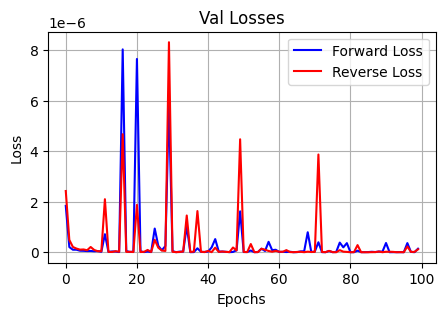

index: 5


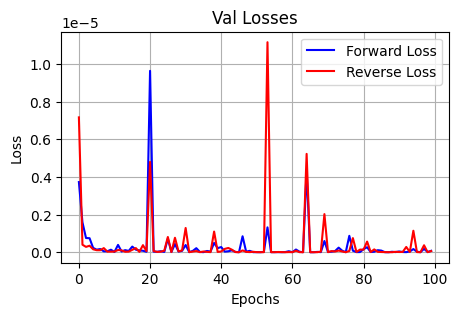

index: 6


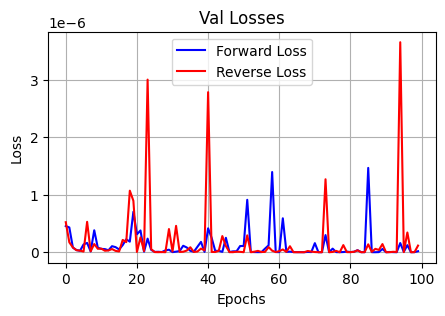

index: 7


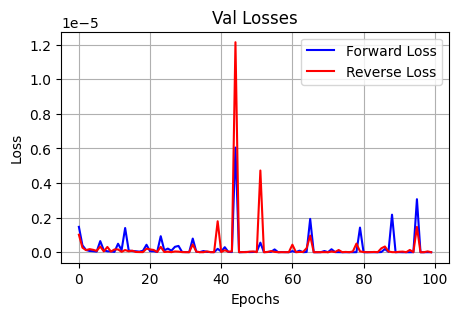

index: 8


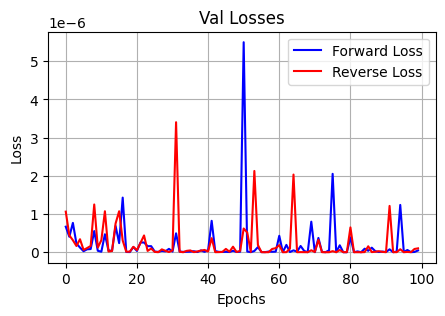

index: 9


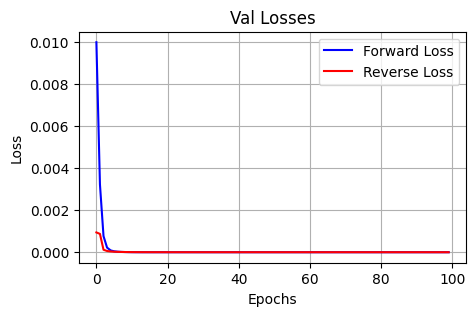

index: 10


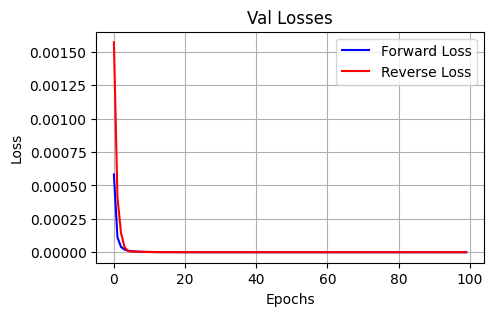

index: 11


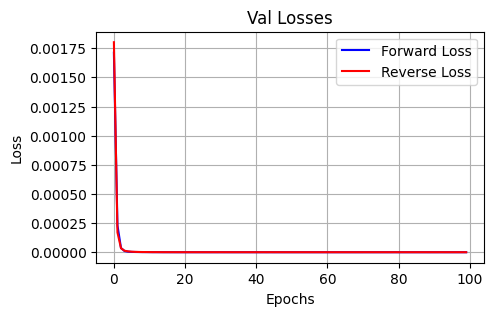

index: 12


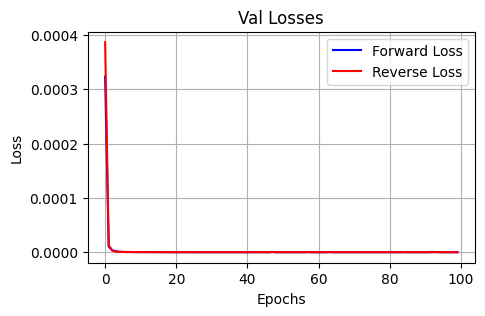

index: 13


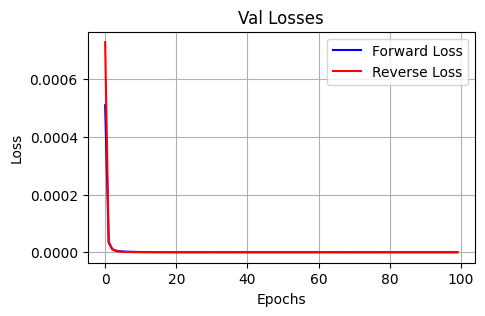

index: 14


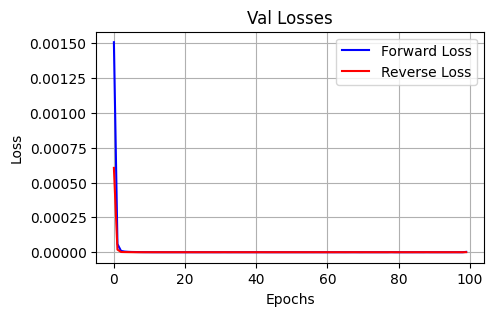

index: 15


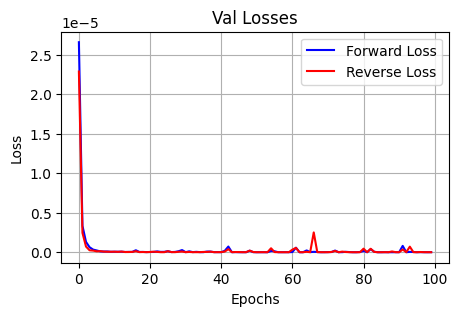

index: 16


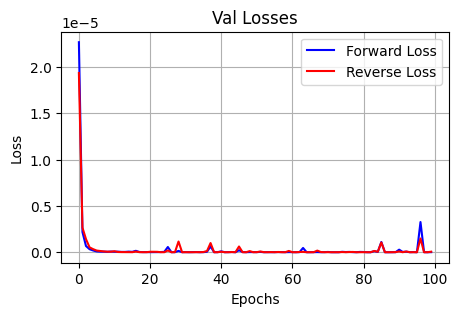

index: 17


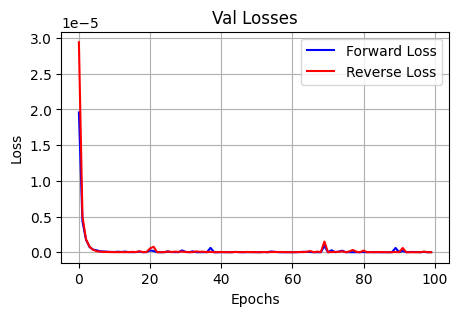

index: 18


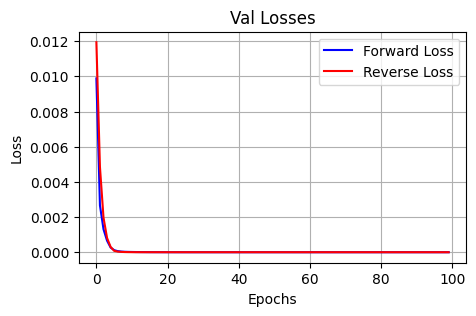

index: 19


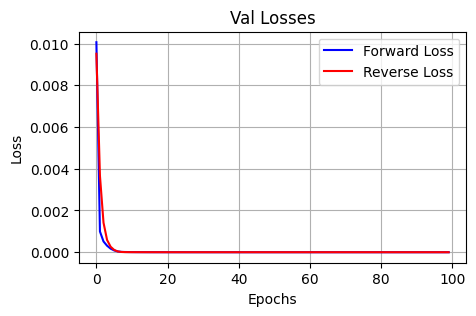

index: 20


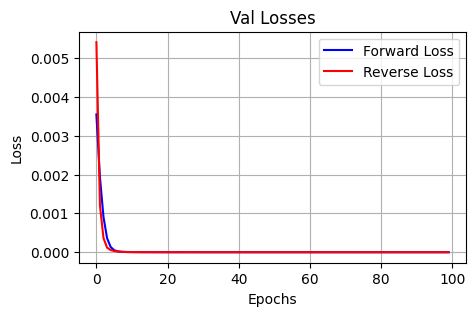

index: 21


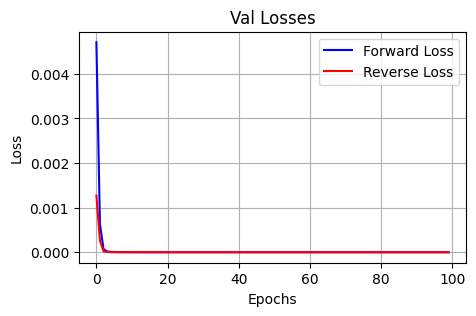

index: 22


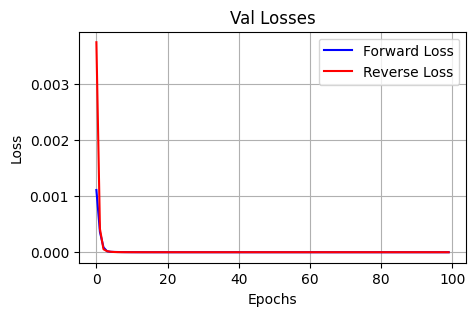

index: 23


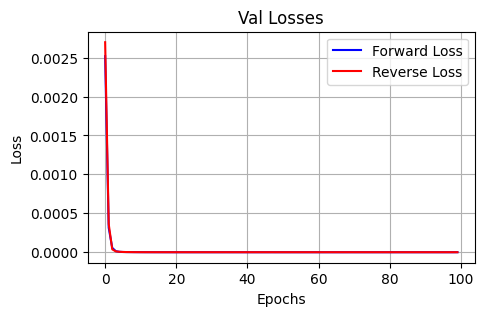

index: 24


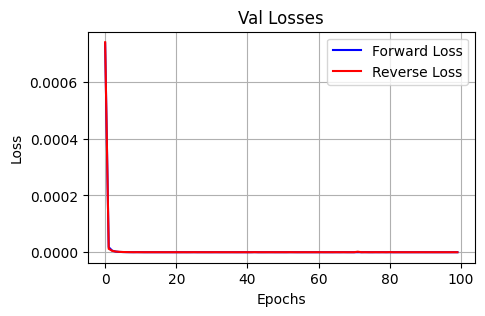

index: 25


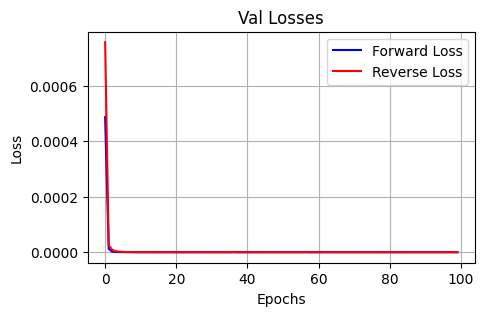

index: 26


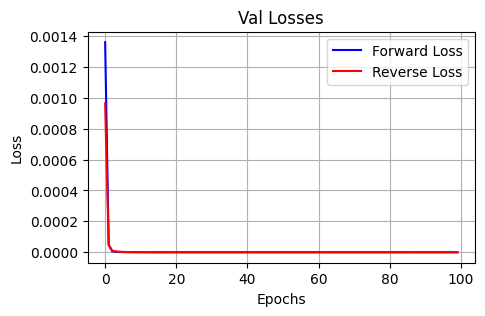

In [117]:
for i in range (27):

    plt.figure(figsize=(5, 3))

    print(f'index: {i}')
    plt.plot(losses_df.iloc[i][2], label='Forward Loss', color='blue')
    plt.plot(losses_df.iloc[i][3], label='Reverse Loss', color='red')

    plt.title('Val Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    # plt.xlim(0, 50)
    plt.show()

### 2-B2

#### Model

In [15]:
class LSTM_B2(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM_B2, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.lstm_forward = nn.LSTM(input_size, hidden_size,  batch_first=True)
        self.lstm_backward = nn.LSTM(input_size, hidden_size, batch_first=True)
        
        self.fc_fwd = nn.Linear(hidden_size, output_size)  
        self.fc_rev = nn.Linear(hidden_size, output_size) 
        
    def forward(self, x):
        # forward LSTM
        out_forward, _ = self.lstm_forward(x)
        
        # backward LSTM
        out_backward, _ = self.lstm_backward(torch.flip(x, [1]))
        
        out_fwd = out_forward[:, -1, :]
        out_rev = out_backward[:, -1, :]
        
        # fully connected layer
        out_fwd = self.fc_fwd(out_fwd)
        out_rev = self.fc_rev(out_rev)
        
        return out_fwd, out_rev

#### Train

In [144]:
input_size = 1
hidden_size = 4
lr = .001
n_epochs = 50

In [145]:
e2b2_net = LSTM_B2(input_size, hidden_size, 1)

In [146]:
loss_fn = nn.MSELoss()
opt = optim.Adam(e2b2_net.parameters(), lr=lr)

In [147]:
losses_fwd = []
losses_rev = []
losses_tot = []

losses_fwd_val = []
losses_rev_val = []
losses_tot_val = []

# best_model_state_dict = None

# best_epoch = -1
# best_val_loss = float('inf')

for epoch in range(n_epochs):
    epoch_loss_fwd = 0.
    epoch_loss_rev = 0.
    epoch_loss_tot = 0.

    epoch_val_fwd = 0.
    epoch_val_rev = 0.
    epoch_val_tot = 0.

    e2b2_net.train()
    for inputs, labels in train_loader_e2b:

        out_fwd, out_rev = e2b2_net(inputs)
        
        labels_fwd = labels[:, 1, :]
        labels_rev = labels[:, 0, :]
        
        loss_fwd = loss_fn(out_fwd, labels_fwd)
        loss_rev = loss_fn(out_rev, labels_rev)
        loss_tot = loss_fwd + loss_rev

        opt.zero_grad()
        loss_tot.backward()
        opt.step()
        
        epoch_loss_fwd += loss_fwd.item()
        epoch_loss_rev += loss_rev.item()
        epoch_loss_tot += loss_tot.item()
       
    losses_fwd.append(epoch_loss_fwd / (len(train_loader_e2b.sampler)))
    losses_rev.append(epoch_loss_rev / (len(train_loader_e2b.sampler)))
    losses_tot.append(epoch_loss_tot / (len(train_loader_e2b.sampler)))

    # validation 
    e2b2_net.eval()  
    with torch.no_grad():
        for inputs_val, labels_val in val_loader_e2b:
        
            out_val = e2b2_net(inputs_val)

            out_fwd_val, out_rev_val = e2b2_net(inputs_val)
        
            labels_fwd_val = labels_val[:, 1, :]
            labels_rev_val = labels_val[:, 0, :]

            val_loss_fwd = loss_fn(out_fwd_val, labels_fwd_val)
            val_loss_rev = loss_fn(out_rev_val, labels_rev_val)
            val_loss_tot = val_loss_rev + val_loss_fwd

            epoch_val_fwd += val_loss_fwd.item()
            epoch_val_rev += val_loss_rev.item()
            epoch_val_tot += val_loss_tot.item()

    val_loss = epoch_val_tot / len(val_loader_e2b.sampler)
    
    losses_fwd_val.append(epoch_val_fwd / (len(val_loader_e2b.sampler)))
    losses_rev_val.append(epoch_val_rev / (len(val_loader_e2b.sampler)))
    losses_tot_val.append(val_loss)
    

    # if val_loss < best_val_loss:
    #     best_val_loss = val_loss
    #     best_model_state_dict = copy.deepcopy(model.state_dict())
    #     best_epoch = epoch




#### Loss Curve

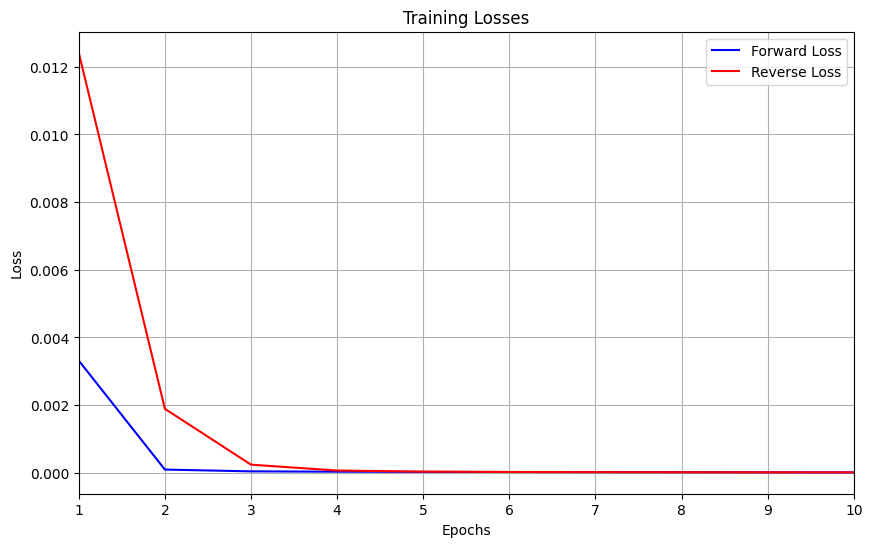

In [148]:
epochs = range(1, len(losses_tot) + 1)

plt.figure(figsize=(10, 6))

plt.plot(epochs, losses_fwd, label='Forward Loss', color='blue')
plt.plot(epochs, losses_rev, label='Reverse Loss', color='red')

plt.xlim(1, 10)
plt.title('Training Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

#### Running the Experiment

In [12]:
lrs = [.005, .001, .0005]
hiddens = [4, 8, 16]
num_runs = 1

In [13]:
results_b2 = []

In [16]:
for lr in lrs:
    for hidden_size in hiddens:
        for i in range(num_runs):

            model = LSTM_B2(1, hidden_size, 1)
            loss_fn = nn.MSELoss()
            opt = optim.Adam(model.parameters(), lr=lr)
            result = train_model_e2b2(model, train_loader_e2b, val_loader_e2b, opt, loss_fn)
            results_b2.append((result, lr, hidden_size, i))

/Users/kevinkaplan/tensorflow-test/env/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


#### Results -- Code

In [17]:
data_e2b2 = {
    'lr': [],
    'hidden_size': [],
    'best_epoch': [],
    'mae_fwd': [],
    'mae_rev': [],
    'mse_fwd': [],
    'mse_rev': []
}

losses_e2b2 = {
    'train_fwd': [],
    'train_rev': [],
    'val_fwd': [],
    'val_rev': []

}

e3_e2b2 = {

    'abs_error_fwd': [],
    'abs_error_rev': [],
    'sq_error_fwd': [],
    'sq_error_rev': [],
    'pct_error_fwd': [],
    'pct_error_rev': [],
    
}

In [26]:
for item in results_b2:
    result, lr, hidden_size, i = item
    best_model_state_dict, best_epoch, losses_fwd_train, losses_fwd_val, losses_rev_train, losses_rev_val = result

    model = LSTM_B2(1, hidden_size, 1)

    model.load_state_dict(best_model_state_dict)

    preds_fwd, true_fwd, preds_rev, true_rev = make_preds_e2b2(model, test_loader_e2b)
    
    mae_fwd, mse_fwd = get_metrics(preds_fwd, true_fwd)
    mae_rev, mse_rev = get_metrics(preds_rev, true_rev)

    abs_error_fwd = np.abs(true_fwd - preds_fwd)
    abs_error_rev = np.abs(true_rev - preds_rev)

    sq_error_fwd = (true_fwd - preds_fwd) ** 2
    sq_error_rev = (true_rev - preds_rev) ** 2

    pct_error_fwd = np.abs((true_fwd - preds_fwd) / true_fwd) * 100
    pct_error_rev = np.abs((true_rev - preds_rev) / true_rev) * 100
        
    
    data_e2b2['lr'].append(lr)
    data_e2b2['hidden_size'].append(hidden_size)
    data_e2b2['best_epoch'].append(best_epoch)

    data_e2b2['mae_fwd'].append(mae_fwd)
    data_e2b2['mse_fwd'].append(mse_fwd)
    data_e2b2['mae_rev'].append(mae_rev)
    data_e2b2['mse_rev'].append(mse_rev)
    
    losses_e2b2['train_fwd'].append(losses_fwd_train)
    losses_e2b2['train_rev'].append(losses_rev_train)
    losses_e2b2['val_fwd'].append(losses_fwd_val)
    losses_e2b2['val_rev'].append(losses_rev_val)

    e3_e2b2['abs_error_fwd'].append(abs_error_fwd)
    e3_e2b2['abs_error_rev'].append(abs_error_rev)
    e3_e2b2['sq_error_fwd'].append(sq_error_fwd)
    e3_e2b2['sq_error_rev'].append(sq_error_rev)
    e3_e2b2['pct_error_fwd'].append(pct_error_fwd)
    e3_e2b2['pct_error_rev'].append(pct_error_rev)
    

In [27]:
df = pd.DataFrame(data_e2b2)

In [28]:
df.head()

lr  hidden_size  best_epoch   mae_fwd   mae_rev       mse_fwd  \
0  0.005            4          43  0.000495  0.000595  3.316997e-07   
1  0.005            8          41  0.000320  0.000320  1.457041e-07   
2  0.005           16          49  0.000167  0.000240  4.519854e-08   
3  0.001            4          49  0.000623  0.000540  5.593274e-07   
4  0.001            8          48  0.000355  0.000335  1.775227e-07   

        mse_rev  
0  5.573989e-07  
1  1.409519e-07  
2  8.173631e-08  
3  4.622933e-07  
4  1.615692e-07

In [29]:
df['pct_diff_mae'] = ((df['mae_rev'] - df['mae_fwd']) / df['mae_fwd']) * 100
df['pct_diff_mse'] = ((df['mse_rev'] - df['mse_fwd']) / df['mse_fwd']) * 100

In [ ]:
df.head()

In [36]:
results = df[['pct_diff_mae', 'pct_diff_mse']]

In [31]:
losses_df = pd.DataFrame(losses_e2b2)

In [32]:
losses_df.head(2)

train_fwd  \
0  [0.0023438990437425673, 1.6122060394991423e-05...   
1  [0.0016551882246058085, 1.0225027926935581e-05...   

                                           train_rev  \
0  [0.0026553597436577547, 4.0977813667268495e-05...   
1  [0.0007743270083301468, 1.5300515286071457e-05...   

                                             val_fwd  \
0  [2.121698597329669e-05, 1.2897932319901884e-05...   
1  [1.5289270944776945e-05, 6.735473303706385e-06...   

                                             val_rev  
0  [7.384813076350838e-05, 2.2448374627856537e-05...  
1  [2.262750087538734e-05, 1.02987996142474e-05, ...

#### Results -- Output

In [37]:
results

pct_diff_mae  pct_diff_mse
0      20.262234     68.043274
1      -0.236544     -3.261538
2      43.233219     80.838402
3     -13.326854    -17.348349
4      -5.658245     -8.986756
5     -35.410355    -61.272263
6     -36.813126    -44.766438
7     -39.222466    -57.741501
8      -0.832454      4.724710
9      20.262234     68.043274
10     -0.236544     -3.261538
11     43.233219     80.838402
12    -13.326854    -17.348349
13     -5.658245     -8.986756
14    -35.410355    -61.272263
15    -36.813126    -44.766438
16    -39.222466    -57.741501
17     -0.832454      4.724710

In [33]:
max_pct_diff_mae = df['pct_diff_mae'].max()
min_pct_diff_mae = df['pct_diff_mae'].min()
avg_pct_diff_mae = df['pct_diff_mae'].mean()

max_pct_diff_mse = df['pct_diff_mse'].max()
min_pct_diff_mse = df['pct_diff_mse'].min()
avg_pct_diff_mse = df['pct_diff_mse'].mean()

print("Maximum pct_diff_mae:", max_pct_diff_mae)
print("Minimum pct_diff_mae:", min_pct_diff_mae)
print("Avg pct_diff_mae:", avg_pct_diff_mae)
print()
print("Maximum pct_diff_mse:", max_pct_diff_mse)
print("Minimum pct_diff_mse:", min_pct_diff_mse)
print("Avg pct_diff_mse:", avg_pct_diff_mse)

Maximum pct_diff_mae: 43.23322
Minimum pct_diff_mae: -39.222466
Avg pct_diff_mae: -7.556065

Maximum pct_diff_mse: 80.8384
Minimum pct_diff_mse: -61.272263
Avg pct_diff_mse: -4.418939


index: 0


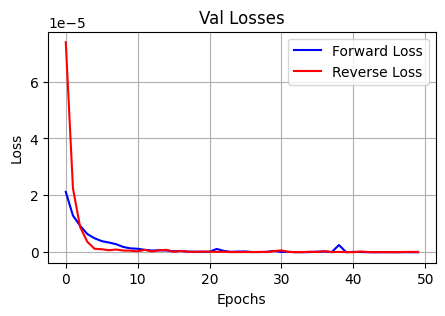

index: 1


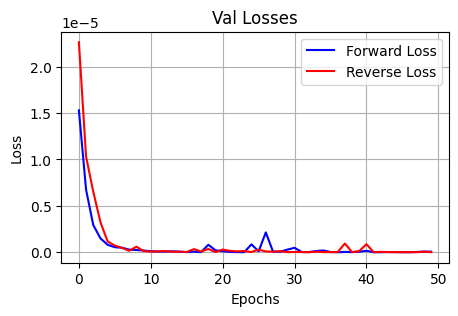

index: 2


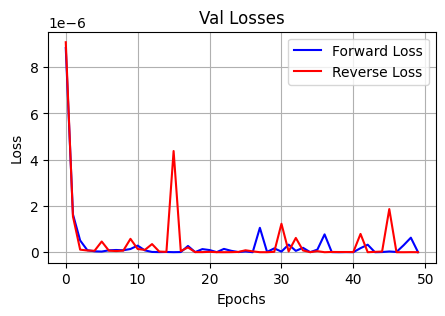

index: 3


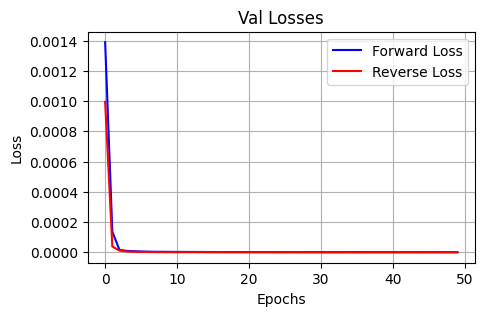

index: 4


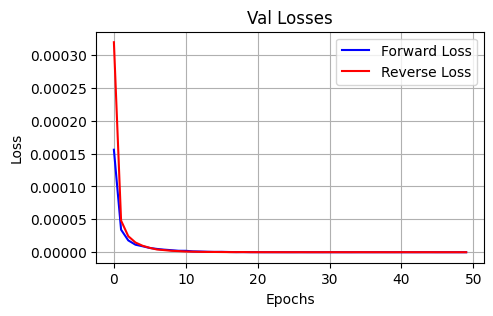

index: 5


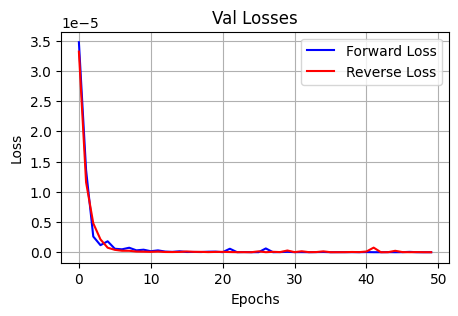

index: 6


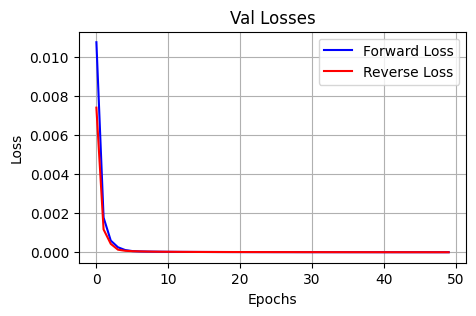

index: 7


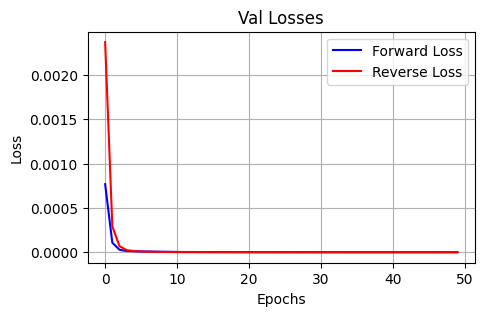

index: 8


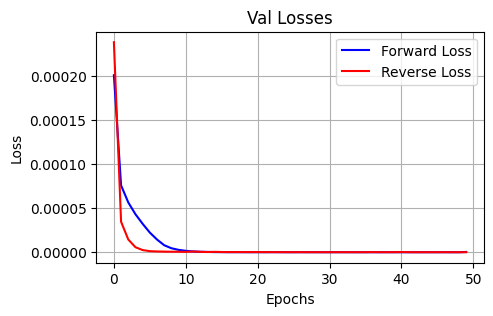

index: 9


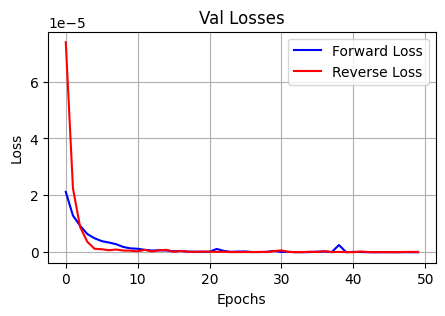

index: 10


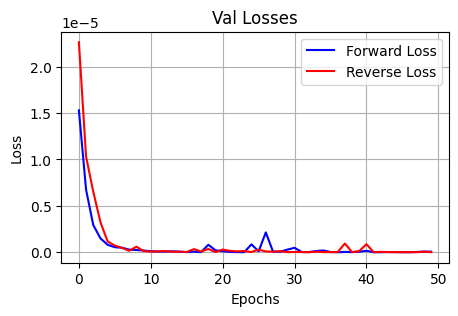

index: 11


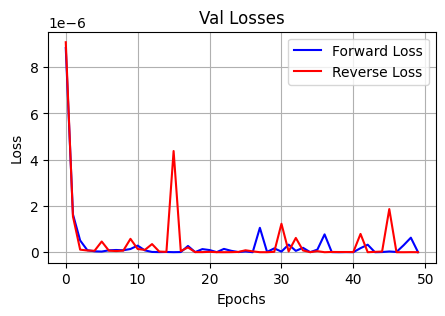

index: 12


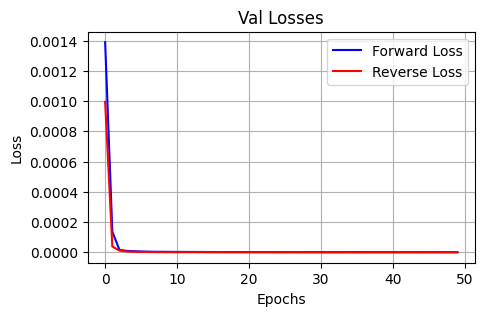

index: 13


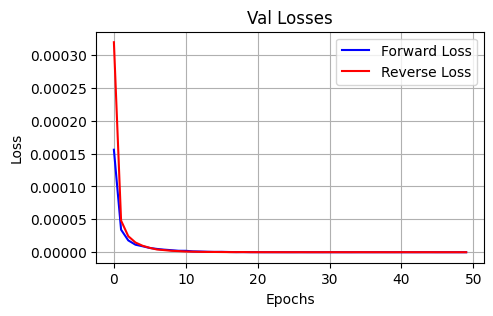

index: 14


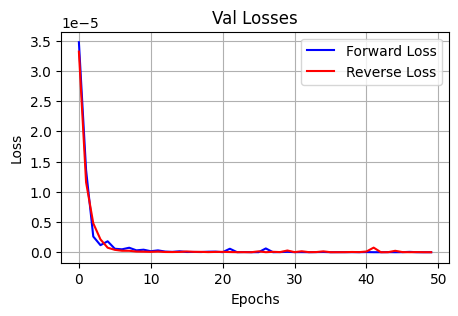

index: 15


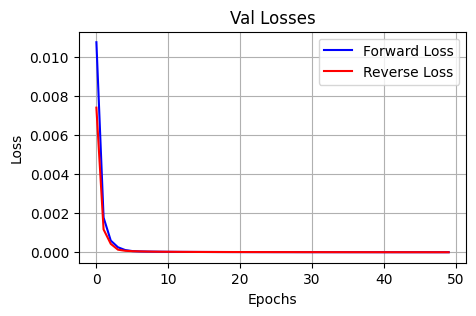

index: 16


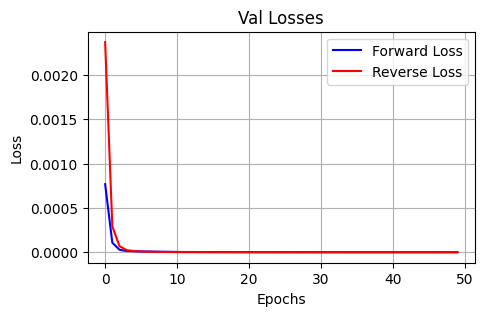

index: 17


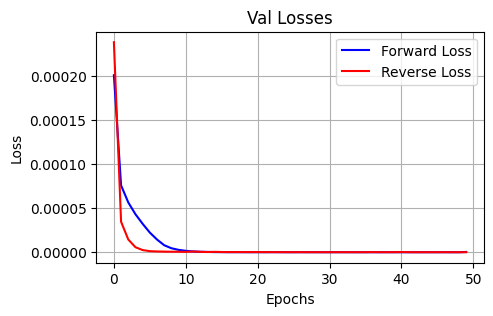

In [34]:
for i in range (18):

    plt.figure(figsize=(5, 3))

    print(f'index: {i}')
    plt.plot(losses_df.iloc[i][2], label='Forward Loss', color='blue')
    plt.plot(losses_df.iloc[i][3], label='Reverse Loss', color='red')

    plt.title('Val Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    # plt.xlim(0, 50)
    plt.show()

## Experiment 3

### Experiment 3 Intro

Here we will look into the question: "How predicting the past may also be relevant in practice: Another question related to
experiment-2 is this. Suppose we have trained a model to minimize L, i.e. predict both the past and the
future. During the test/evaluation phase, is there a correlation between the accuracy of the backward
and forward prediction? Notice that if there is such a correlation, that would be a very interesting
information to have when the model is deployed. During deployment, we will always be able to check
the accuracy of the past prediction (because we know the past!), and using the correlation we may be
able to have a degree of certainty for the future prediction. (On the other hand, if the past prediction is
not accurate that may indicate market volatility etc)."

We can look into this now with some stock market data.  I have selected the S&P 500 price index (ticker: ^GSPC), which is a non-tradeable price index which tracks the performance of 500 large-cap companies in the US. I selected this over a single stock as it hopefully will eliminate certain variances and volatility that may be associated with a single stock, while still capturing market trends as a whole. We will see an example and also use results from experiment 2A on Financial Data.

### Data

In [166]:
ticker = '^GSPC'
start = '1974-01-01'
end = '2024-01-01'

df = yf.download(ticker, start=start, end=end)
df['Percent Change'] = df['Close'].pct_change()
df.dropna(inplace=True)
df.drop(['Adj Close', 'Open', 'High', 'Low', 'Volume', 'Close'], axis=1, inplace=True)

[*********************100%%**********************]  1 of 1 completed


In [168]:
train_percent = 0.6  
val_percent = 0.2    
test_percent = 0.2   

total_entries = len(df)

train_cutoff = int(train_percent * total_entries)
val_cutoff = int((train_percent + val_percent) * total_entries)

train_df = df.iloc[:train_cutoff]
val_df = df.iloc[train_cutoff:val_cutoff]
test_df = df.iloc[val_cutoff:]

print("Training set:")
print(train_df.head())
print("\nValidation set:")
print(val_df.head())
print("\nTest set:")
print(test_df.head())

Training set:
            Percent Change
Date                      
1974-01-03        0.021704
1974-01-04       -0.009018
1974-01-07       -0.008392
1974-01-08       -0.019884
1974-01-09       -0.028090

Validation set:
            Percent Change
Date                      
2003-12-16        0.006638
2003-12-17        0.001256
2003-12-18        0.011798
2003-12-19       -0.000477
2003-12-22        0.003931

Test set:
            Percent Change
Date                      
2013-12-23        0.005318
2013-12-24        0.002916
2013-12-26        0.004746
2013-12-27       -0.000337
2013-12-30       -0.000179


In [169]:
scaler = MinMaxScaler(feature_range=(-1, 1))

train_scaled = scaler.fit_transform(train_df)
val_scaled = scaler.transform(val_df)
test_scaled = scaler.transform(test_df)

In [170]:
def make_seqs(data, tau):
    x = torch.tensor(data, dtype=torch.float32)
    x = x.flatten()
    T = len(x)
    
    # generate sequences and labels (yrev = x0 yfwd = xt, xt[xt-tau...xt-1])
    features = torch.zeros((T - tau, tau))
    for i in range(tau):
        features[:, i] = x[i: T - tau + i]

    labels_fwd = x[tau:].reshape((-1, 1))
    labels_rev = x[0: T - (tau+1)].reshape((-1, 1))

    features = features.reshape(-1, tau, 1)

    labels_fwd = labels_fwd[1:]
    features = features[1:]

    labels = torch.cat((labels_rev, labels_fwd), dim=1).reshape(-1, 2, 1)

    return features, labels

In [186]:
tau = 150

In [187]:
X_train, y_train = make_seqs(train_scaled, tau)
X_val, y_val = make_seqs(val_scaled, tau)
X_test, y_test = make_seqs(test_scaled, tau)


In [188]:
# datasets
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)
# loaders
train_loader_e3 = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader_e3 = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)
test_loader_e3= DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

### Model

In [189]:
input_size = 1
hidden_size = 4

In [190]:
class LSTM_E3(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM_E3, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.lstm_forward = nn.LSTM(input_size, hidden_size,  batch_first=True)
        self.lstm_backward = nn.LSTM(input_size, hidden_size, batch_first=True)
        
        self.fc_fwd = nn.Linear(hidden_size, output_size)  
        self.fc_rev = nn.Linear(hidden_size, output_size) 
        
    def forward(self, x):
        # forward LSTM
        out_forward, _ = self.lstm_forward(x)
        
        # backward LSTM
        out_backward, _ = self.lstm_backward(torch.flip(x, [0]))
        
        out_fwd = out_forward[:, -1, :]
        out_rev = out_backward[:, -1, :]
        
        # fully connected layer
        out_fwd = self.fc_fwd(out_fwd)
        out_rev = self.fc_rev(out_rev)
        
        return out_fwd, out_rev

In [191]:
e3_model = LSTM_E3(input_size, hidden_size, 1)

### Example Training and Testing

#### Train

In [59]:
# TODO Train

In [195]:
lr = .0001
n_epochs = 250

In [196]:
loss_fn = nn.MSELoss()
opt = optim.Adam(e3_model.parameters(), lr=lr)

In [197]:
losses_fwd_train = []
losses_rev_train = []
losses_tot_train = []

losses_fwd_val = []
losses_rev_val = []
losses_tot_val = []

In [198]:
for epoch in range(n_epochs):
    # print(epoch_loss_tot)
    epoch_loss_fwd_train = 0.
    epoch_loss_rev_train = 0.
    epoch_loss_tot_train = 0.

    epoch_loss_fwd_val = 0.
    epoch_loss_rev_val= 0.
    epoch_loss_tot_val = 0.

    e3_model.train()
    
    for inputs, labels in train_loader_e3:
        
        out_fwd, out_rev = e3_model(inputs)
        
        labels_fwd = labels[:, 1, :]
        labels_rev = labels[:, 0, :]
        
        # print(outputs)
        loss_fwd_train = loss_fn(out_fwd, labels_fwd)
        loss_rev_train = loss_fn(out_rev, labels_rev)
        loss_tot_train = loss_fwd_train + loss_rev_train

        opt.zero_grad()
        loss_tot_train.backward()
        opt.step()
        
        epoch_loss_fwd_train += loss_fwd_train.item()
        epoch_loss_rev_train += loss_rev_train.item()
        epoch_loss_tot_train += loss_tot_train.item()
       
    losses_fwd_train.append(epoch_loss_fwd_train / len(train_loader_e3.sampler))
    losses_rev_train.append(epoch_loss_rev_train / len(train_loader_e3.sampler))
    losses_tot_train.append(epoch_loss_tot_train / len(train_loader_e3.sampler))

    # Validation 
    e3_model.eval()  
    with torch.no_grad():
        for inputs_val, labels_val in val_loader_e3:
            val_out_fwd, val_out_rev = e3_model(inputs_val)
            val_labels_fwd = labels_val[:, 1, :]
            val_labels_rev = labels_val[:, 0, :]

            loss_fwd_val = loss_fn(val_out_fwd, val_labels_fwd)
            loss_rev_val = loss_fn(val_out_rev, val_labels_rev)
            loss_tot_val = loss_fwd_val + loss_rev_val

            epoch_loss_fwd_val += loss_fwd_val.item()
            epoch_loss_rev_val += loss_rev_val.item()
            epoch_loss_tot_val += loss_tot_val.item()

    losses_fwd_val.append(epoch_loss_fwd_val / len(val_loader_e3.sampler))
    losses_rev_val.append(epoch_loss_rev_val / len(val_loader_e3.sampler))
    losses_tot_val.append(epoch_loss_tot_val / len(val_loader_e3.sampler))

In [199]:
import os
import subprocess

def play_system_sound():
    try:
        # Use the afplay command to play the system beep sound
        subprocess.call(["afplay", "/System/Library/Sounds/Ping.aiff"])
    except FileNotFoundError:
        # If afplay is not available (e.g., on some versions of macOS), use the fallback method
        print('\a')

# Call the function to play the system sound
play_system_sound()

#### Loss Curves

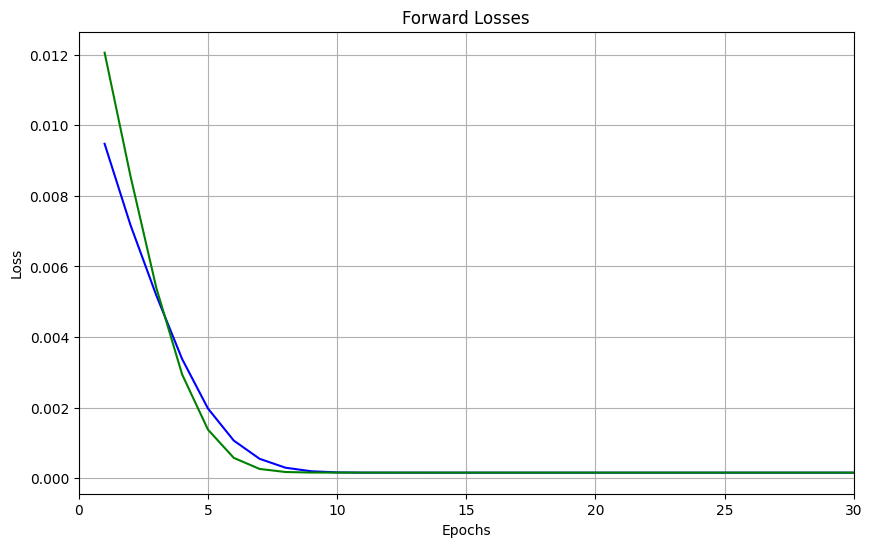

In [203]:
epochs = range(1, len(losses_fwd_train) + 1)

plt.figure(figsize=(10, 6))

plt.plot(epochs, losses_fwd_train, label='Fwd Loss', color='blue')
plt.plot(epochs, losses_rev_train, label='Rev Loss', color='green')
# plt.plot(epochs, losses_val_fwd label='Val Loss', color='red')

plt.title('Forward Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xlim(0, 30)
# plt.legend()
plt.grid(True)
plt.show()

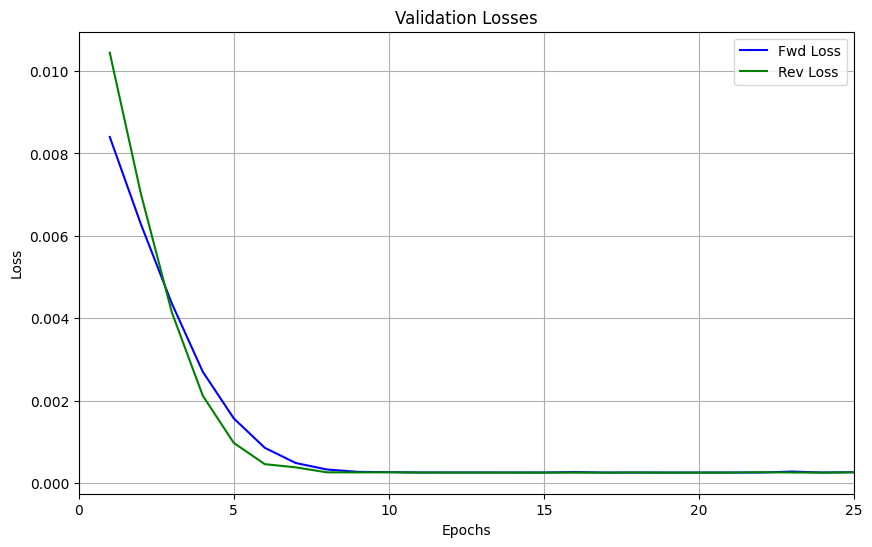

In [207]:
epochs = range(1, len(losses_fwd_val) + 1)

plt.figure(figsize=(10, 6))

plt.plot(epochs, losses_fwd_val, label='Fwd Loss', color='blue')
plt.plot(epochs, losses_rev_val, label='Rev Loss', color='green')
# plt.plot(epochs, losses_val_fwd label='Val Loss', color='red')

plt.title('Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xlim(0, 25)
plt.legend()
plt.grid(True)
plt.show()

#### Predictions

In [211]:
preds_fwd = []
true_fwd = []
preds_rev = []
true_rev= []

# Set the model to evaluation mode
e3_model.eval()

# Make predictions
with torch.no_grad():
     for inputs, labels in test_loader_e3:
        
        out_fwd, out_rev = e3_model(inputs)
        
        labels_fwd = labels[:, 1, :]
        labels_rev = labels[:, 0, :]

        preds_fwd.append(out_fwd.cpu().numpy())
        true_fwd.append(labels_fwd.cpu().numpy())

        preds_rev.append(out_rev.cpu().numpy())
        true_rev.append(labels_rev.cpu().numpy())

       
preds_fwd = np.concatenate(preds_fwd).flatten()
true_fwd = np.concatenate(true_fwd).flatten()

preds_rev = np.concatenate(preds_rev).flatten()
true_rev = np.concatenate(true_rev).flatten()

#### Correlation

We are trying to determine if the model has a correlation in accuracy between the forward and backward predictions on a given sequence/data point.  To do this, we can calculate an error on a per point basis for both the forward and backward predictions.  Then we can compare the error between the two to see if they are correlated in any way.  Three error types were used, the absolute, the square error, and the percent error. Then the pearson correlation coefficent was calculated to see if there was any evidence of a linear correlation.  Spearman was also used to determine if a monotonic relationship between the datas was present.

In [226]:
# x0 [x1, x2, x3] x4
abs_error_fwd = np.abs(true_fwd - preds_fwd)
abs_error_rev = np.abs(true_rev - preds_rev)

sq_error_fwd = (true_fwd - preds_fwd) ** 2
sq_error_rev = (true_rev - preds_rev) ** 2

pct_error_fwd = np.abs((true_fwd - preds_fwd) / true_fwd) * 100
pct_error_rev = np.abs((true_rev - preds_rev) / true_rev) * 100


In [43]:
from scipy.stats import pearsonr
from scipy.stats import spearmanr

In [229]:
coeff_abs, p_val_abs = pearsonr(abs_error_fwd, abs_error_rev)
coeff_sq, p_val_sq = pearsonr(sq_error_fwd, sq_error_rev)
coeff_pct, p_val_pct = pearsonr(pct_error_fwd, pct_error_rev)

In [230]:
coeff_abs, p_val_abs

(0.07119927556238412, 0.0005214751467552232)

In [231]:
coeff_sq, p_val_sq

(0.010934947686033772, 0.5945946773949637)

In [232]:
coeff_pct, p_val_pct

(0.007392027593247722, 0.7190307461925477)

In [233]:
coeff_abs, p_val_abs = spearmanr(abs_error_fwd, abs_error_rev)
coeff_sq, p_val_sq = spearmanr(sq_error_fwd, sq_error_rev)
coeff_pct, p_val_pct = spearmanr(pct_error_fwd, pct_error_rev)

In [234]:
coeff_abs, p_val_abs

(0.07703367078522019, 0.0001736213097769123)

In [235]:
coeff_sq, p_val_sq

(0.07703367078522019, 0.0001736213097769123)

In [236]:
coeff_pct, p_val_pct

(0.07728896215600382, 0.00016517067654458077)

### Testing/Multiple Runs

Using the data obtained from the E2A Financial data multiple run, we can get some results for this experiment as well, see the code from that section to see where data came from

In [40]:
e3_e2b2_df = pd.DataFrame(e3_e2fin)

In [41]:
e3_e2b2_df.head()

abs_error_fwd  \
0  [0.04372987, 0.034913838, 0.010551661, 0.01297...   
1  [0.046426803, 0.0329113, 0.01384449, 0.0107839...   
2  [0.048518777, 0.02881807, 0.012683809, 0.00827...   
3  [0.045988232, 0.03272134, 0.01079911, 0.011309...   
4  [0.046394438, 0.033042163, 0.013953, 0.0091975...   

                                       abs_error_rev  \
0  [0.004114598, 0.07918593, 0.022871971, 0.00291...   
1  [0.0037428439, 0.07836479, 0.022343606, 0.0062...   
2  [0.008871496, 0.082983345, 0.027679086, 0.0039...   
3  [0.0016963184, 0.075775385, 0.020276815, 0.011...   
4  [0.009777874, 0.08300945, 0.02927944, 0.002809...   

                                        sq_error_fwd  \
0  [0.0019123016, 0.0012189761, 0.000111337555, 0...   
1  [0.002155448, 0.0010831538, 0.00019166991, 0.0...   
2  [0.0023540717, 0.00083048124, 0.000160879, 6.8...   
3  [0.0021149174, 0.0010706862, 0.00011662077, 0....   
4  [0.0021524439, 0.0010917846, 0.00019468622, 8....   

                                        sq_error_rev  \
0  [1.6929916e-05, 0.006270412, 0.0005231271, 8.4...   
1  [1.40088805e-05, 0.00614104, 0.00049923675, 3....   
2  [7.870344e-05, 0.0068862354, 0.0007661318, 1.5...   
3  [2.8774962e-06, 0.005741909, 0.0004111492, 0.0...   
4  [9.560682e-05, 0.006890569, 0.00085728563, 7.8...   

                                       pct_error_fwd  \
0  [12.826032, 8.36046, 2.802543, 3.264157, 0.953...   
1  [13.617046, 7.880933, 3.677125, 2.713599, 1.75...   
2  [14.230624, 6.900769, 3.3688455, 2.0816815, 1....   
3  [13.488412, 7.8354454, 2.8682659, 2.8458858, 1...   
4  [13.607553, 7.912269, 3.7059455, 2.3143985, 2....   

                                       pct_error_rev  
0  [1.0485814, 16.939224, 5.51479, 0.76260316, 16...  
1  [0.95384204, 16.763569, 5.387393, 1.6372061, 1...  
2  [2.260849, 17.751556, 6.6738605, 1.0366161, 16...  
3  [0.4322969, 16.20965, 4.889057, 2.9276876, 15....  
4  [2.4918342, 17.75714, 7.0597315, 0.7353656, 16...

In [45]:
def calc_pearson(column1, column2):
    corr, p_val = pearsonr(column1, column2)
    return corr, p_val

In [51]:
def calc_spearman(column1, column2):
    corr, p_val = spearmanr(column1, column2)
    return corr, p_val

In [50]:
e3_e2b2_df['pears_abs'], e3_e2b2_df['p_vpears_abs'] = zip(*e3_e2b2_df.apply(lambda row: calc_pearson(row['abs_error_fwd'], row['abs_error_rev']), axis=1))
e3_e2b2_df['pears_sq'], e3_e2b2_df['p_vpears_sq'] = zip(*e3_e2b2_df.apply(lambda row: calc_pearson(row['sq_error_fwd'], row['sq_error_rev']), axis=1))
e3_e2b2_df['pears_pct'], e3_e2b2_df['p_vpears_pct'] = zip(*e3_e2b2_df.apply(lambda row: calc_pearson(row['pct_error_fwd'], row['pct_error_rev']), axis=1))

e3_e2b2_df['spear_abs'], e3_e2b2_df['p_vspear_abs'] = zip(*e3_e2b2_df.apply(lambda row: calc_spearman(row['abs_error_fwd'], row['abs_error_rev']), axis=1))
e3_e2b2_df['spear_sq'], e3_e2b2_df['p_vspear_sq'] = zip(*e3_e2b2_df.apply(lambda row: calc_spearman(row['sq_error_fwd'], row['sq_error_rev']), axis=1))
e3_e2b2_df['spear_pct'], e3_e2b2_df['p_vspear_pct'] = zip(*e3_e2b2_df.apply(lambda row: calc_spearman(row['pct_error_fwd'], row['pct_error_rev']), axis=1))

In [51]:
results_pears = e3_e2b2_df[['pears_abs', 'p_vpears_abs', 'pears_sq', 'p_vpears_sq', 'pears_pct', 'p_vpears_pct']]
results_spear = e3_e2b2_df[['spear_abs', 'p_vspear_abs', 'spear_sq', 'p_vspear_sq', 'spear_pct', 'p_vspear_pct']]

### Results

In [52]:
results_pears

pears_abs  p_vpears_abs  pears_sq  p_vpears_sq  pears_pct  p_vpears_pct
0   -0.074499      0.000262 -0.024338     0.233607  -0.010260      0.615634
1   -0.075852      0.000202 -0.023489     0.250316  -0.010397      0.610895
2   -0.076197      0.000188 -0.025786     0.206944  -0.010047      0.622961
3   -0.077162      0.000156 -0.025661     0.209161  -0.010536      0.606133
4   -0.073213      0.000334 -0.020758     0.309680  -0.009312      0.648635
5   -0.069294      0.000687 -0.020950     0.305242  -0.008813      0.666275
6   -0.076647      0.000173 -0.026155     0.200524  -0.009913      0.627606
7   -0.076137      0.000191 -0.026016     0.202918  -0.010011      0.624201
8   -0.075086      0.000234 -0.025940     0.204246  -0.009635      0.637286
9   -0.075559      0.000213 -0.025603     0.210194  -0.010066      0.622299
10  -0.076333      0.000183 -0.025970     0.203728  -0.010137      0.619841
11  -0.077143      0.000156 -0.025133     0.218674  -0.010450      0.609097
12  -0.075588      0.000212 -0.025664     0.209102  -0.009740      0.633645
13  -0.076636      0.000173 -0.026438     0.195694  -0.009917      0.627479
14  -0.076795      0.000168 -0.025898     0.204984  -0.010118      0.620514
15  -0.075305      0.000224 -0.025679     0.208829  -0.009986      0.625095
16  -0.075699      0.000208 -0.025414     0.213580  -0.010005      0.624418
17  -0.076098      0.000192 -0.025220     0.217085  -0.010161      0.619020

In [ ]:
# results_spear

#### E2B2 Data

##### Code

In [38]:
e3_e2b2_df = pd.DataFrame(e3_e2b2)

In [39]:
e3_e2b2_df.head()

abs_error_fwd  \
0  [4.3988228e-05, 1.4215708e-05, 1.0609627e-05, ...   
1  [0.00028559566, 0.00030487776, 0.0003245175, 0...   
2  [0.00020879507, 0.00021117926, 0.00021246076, ...   
3  [0.000546962, 0.0005144179, 0.00048094988, 0.0...   
4  [0.00034359097, 0.00036358833, 0.0003825128, 0...   

                                       abs_error_rev  \
0  [0.00020217896, 0.0001771748, 0.00015854836, 0...   
1  [5.6266785e-05, 7.584691e-05, 8.666515e-05, 9....   
2  [0.00034624338, 0.0003323853, 0.00032615662, 0...   
3  [0.00049960613, 0.0005199611, 0.0005468726, 0....   
4  [7.098913e-05, 5.1409006e-05, 3.796816e-05, 2....   

                                        sq_error_fwd  \
0  [1.9349642e-09, 2.0208635e-10, 1.1256418e-10, ...   
1  [8.156488e-08, 9.2950444e-08, 1.053116e-07, 1....   
2  [4.359538e-08, 4.459668e-08, 4.5139572e-08, 4....   
3  [2.9916745e-07, 2.6462575e-07, 2.3131278e-07, ...   
4  [1.1805476e-07, 1.3219648e-07, 1.4631605e-07, ...   

                                        sq_error_rev  \
0  [4.087633e-08, 3.139091e-08, 2.5137581e-08, 1....   
1  [3.165951e-09, 5.752754e-09, 7.510849e-09, 9.0...   
2  [1.1988448e-07, 1.1047999e-07, 1.0637814e-07, ...   
3  [2.4960627e-07, 2.7035958e-07, 2.9906965e-07, ...   
4  [5.039457e-09, 2.642886e-09, 1.4415811e-09, 5....   

                                       pct_error_fwd  \
0  [0.009543608, 0.003026091, 0.002216909, 0.0067...   
1  [0.06196233, 0.064899184, 0.06780877, 0.070785...   
2  [0.04529981, 0.04495363, 0.044394225, 0.043523...   
3  [0.118667915, 0.109503895, 0.100495726, 0.0915...   
4  [0.074544884, 0.07739688, 0.07992704, 0.082245...   

                                       pct_error_rev  
0  [0.03992746, 0.035597138, 0.032421514, 0.02909...  
1  [0.011111888, 0.015238808, 0.017722135, 0.0197...  
2  [0.068378136, 0.066781305, 0.06669568, 0.06673...  
3  [0.098665096, 0.10446817, 0.11182984, 0.119451...  
4  [0.014019341, 0.010328858, 0.0077640996, 0.004...

In [52]:
e3_e2b2_df['pears_abs'], e3_e2b2_df['p_vpears_abs'] = zip(*e3_e2b2_df.apply(lambda row: calc_pearson(row['abs_error_fwd'], row['abs_error_rev']), axis=1))
e3_e2b2_df['pears_sq'], e3_e2b2_df['p_vpears_sq'] = zip(*e3_e2b2_df.apply(lambda row: calc_pearson(row['sq_error_fwd'], row['sq_error_rev']), axis=1))
e3_e2b2_df['pears_pct'], e3_e2b2_df['p_vpears_pct'] = zip(*e3_e2b2_df.apply(lambda row: calc_pearson(row['pct_error_fwd'], row['pct_error_rev']), axis=1))

e3_e2b2_df['spear_abs'], e3_e2b2_df['p_vspear_abs'] = zip(*e3_e2b2_df.apply(lambda row: calc_spearman(row['abs_error_fwd'], row['abs_error_rev']), axis=1))
e3_e2b2_df['spear_sq'], e3_e2b2_df['p_vspear_sq'] = zip(*e3_e2b2_df.apply(lambda row: calc_spearman(row['sq_error_fwd'], row['sq_error_rev']), axis=1))
e3_e2b2_df['spear_pct'], e3_e2b2_df['p_vspear_pct'] = zip(*e3_e2b2_df.apply(lambda row: calc_spearman(row['pct_error_fwd'], row['pct_error_rev']), axis=1))

In [53]:
results_pears_e2b2 = e3_e2b2_df[['pears_abs', 'p_vpears_abs', 'pears_sq', 'p_vpears_sq', 'pears_pct', 'p_vpears_pct']]
results_spear_e2b2 = e3_e2b2_df[['spear_abs', 'p_vspear_abs', 'spear_sq', 'p_vspear_sq', 'spear_pct', 'p_vspear_pct']]

##### Results

In [54]:
results_pears_e2b2

pears_abs   p_vpears_abs  pears_sq    p_vpears_sq  pears_pct  p_vpears_pct
0    0.265543   5.182102e-32  0.300155   7.796822e-41  -0.006325      0.782974
1   -0.334669   6.377214e-51 -0.285975   4.552513e-37  -0.009926      0.665548
2    0.083252   2.814189e-04  0.135830   2.802214e-09  -0.008568      0.709037
3   -0.132808   6.269837e-09 -0.068478   2.830031e-03  -0.009879      0.667029
4   -0.033056   1.498811e-01  0.010712   6.408613e-01  -0.009443      0.680898
5   -0.065547   4.269111e-03 -0.133051   5.881692e-09  -0.008440      0.713207
6   -0.200890   9.677753e-19 -0.138137   1.496940e-09  -0.005863      0.798479
7    0.155606   9.230423e-12  0.157717   4.789023e-12  -0.008656      0.706214
8    0.524951  5.584942e-135  0.642245  2.363633e-221  -0.006193      0.787395
9    0.265543   5.182102e-32  0.300155   7.796822e-41  -0.006325      0.782974
10  -0.334669   6.377214e-51 -0.285975   4.552513e-37  -0.009926      0.665548
11   0.083252   2.814189e-04  0.135830   2.802214e-09  -0.008568      0.709037
12  -0.132808   6.269837e-09 -0.068478   2.830031e-03  -0.009879      0.667029
13  -0.033056   1.498811e-01  0.010712   6.408613e-01  -0.009443      0.680898
14  -0.065547   4.269111e-03 -0.133051   5.881692e-09  -0.008440      0.713207
15  -0.200890   9.677753e-19 -0.138137   1.496940e-09  -0.005863      0.798479
16   0.155606   9.230423e-12  0.157717   4.789023e-12  -0.008656      0.706214
17   0.524951  5.584942e-135  0.642245  2.363633e-221  -0.006193      0.787395

In [55]:
results_spear_e2b2

spear_abs  p_vspear_abs  spear_sq   p_vspear_sq  spear_pct  p_vspear_pct
0    0.221859  1.320606e-22  0.221859  1.320606e-22  -0.054316  1.792670e-02
1   -0.328449  5.266166e-49 -0.328449  5.266166e-49  -0.146555  1.390140e-10
2    0.056583  1.365944e-02  0.056583  1.365944e-02   0.156972  6.042665e-12
3   -0.179231  3.572611e-15 -0.179231  3.572611e-15  -0.153717  1.647724e-11
4   -0.061466  7.377892e-03 -0.061466  7.377892e-03   0.046134  4.441467e-02
5    0.037042  1.065943e-01  0.037042  1.065943e-01  -0.088225  1.183099e-04
6   -0.283218  2.320873e-36 -0.283218  2.320873e-36  -0.076073  9.075657e-04
7    0.136946  2.071555e-09  0.136946  2.071555e-09  -0.035346  1.236224e-01
8    0.377001  3.432747e-65  0.377001  3.432747e-65   0.133189  5.670352e-09
9    0.221859  1.320606e-22  0.221859  1.320606e-22  -0.054316  1.792670e-02
10  -0.328449  5.266166e-49 -0.328449  5.266166e-49  -0.146555  1.390140e-10
11   0.056583  1.365944e-02  0.056583  1.365944e-02   0.156972  6.042665e-12
12  -0.179231  3.572611e-15 -0.179231  3.572611e-15  -0.153717  1.647724e-11
13  -0.061466  7.377892e-03 -0.061466  7.377892e-03   0.046134  4.441467e-02
14   0.037042  1.065943e-01  0.037042  1.065943e-01  -0.088225  1.183099e-04
15  -0.283218  2.320873e-36 -0.283218  2.320873e-36  -0.076073  9.075657e-04
16   0.136946  2.071555e-09  0.136946  2.071555e-09  -0.035346  1.236224e-01
17   0.377001  3.432747e-65  0.377001  3.432747e-65   0.133189  5.670352e-09

## Conclusion

In this project we looked into time series with LSTMs.  The goal was to see if forward and reverse predictions were in anyway correllated or if there was evidence of 'an arrow of time.'  Several experiments were conducted, and various results were obtained.  On the one hand, with separate models with forward and reverse datasets in experiment one, there was some evidence that the reverse model converges more quickly/the loss decreases more rapidly.  We also saw evidence for this in experiment 2, where the losses for the reverse appeared to be reduced more rapidly again, and the final models had better performance in the reverse direction as well.  On the other hand, we did not see as much evidence for this for the other experiment 2 models, and could not obtain solid evidence for a correllation between the forward and reverse accuracies in experiment 3.  However, there were instances in some runs (E2B2 data, Exp 3), where certain models did have correllated data.  

At this point, there is certainly more work to be done to conclusivley say anything in one direction or another, and I would continue running these experiments with more runs to obtain more data.  From there confidence intervals could be determined in order to conclusivley determine if the evidence supports any claims.  I would also like to examine in more depth the parts of the project where results seemed more promising.  In addition, more work exploring the correllation could be done as well.  